In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import time
from tqdm import tqdm
from utils import*
import gc
import scipy as scipy

from scipy.sparse import csc_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# .Obj file handling part

In [2]:
points_c=get_file_obj("./data/bun_zipper_res2.obj")

In [3]:
print(points_c.shape)

torch.Size([8171, 6])


In [4]:
dico=dict()
bord=get_borders(points_c)

create_quadtree(dico,0,11,points_c,bord,"")

In [5]:
bord=get_borders(points_c)

In [6]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

def get_dico_final(dico,D):
    new_dico=dict()

    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):

            for i in range(1,9):
                tmp_node=node[:-1]+str(i)
                new_dico[tmp_node]=dico[tmp_node]
    return new_dico
        

def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,6))
    o_s=torch.ones((nb_s,8,5)) #interpolation weight , width , center
    L_indexes=dict()
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,border_father,l_points=dico[node]

            for p in l_points:
                s_p[cpt_p]=p.clone()

                gx,dx,gy,dy,gz,dz=border_father

                tmp_o_vec=torch.empty((8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    w=(s_p[cpt_p,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[7,0]=u*(1-v)*(1-w)
                        
                
                
                
                o_s[cpt_p]=tmp_o_vec.clone()

                if node[:-2] in L_indexes:
                    L_indexes[node[:-2]][0].append(cpt_p)
                else:
                    _,new_c,_,_,_,_=dico[node[:-2]]
                    L_indexes[node[:-2]]=([cpt_p],new_c)
                    
                
                cpt_p+=1
    return s_p,o_s,L_indexes


def get_V_tmp(coords_grid,l_o,l_s):
    #q [ r_x , r_y , r_z,  3 ]
    #     0    1     2    3

    q=coords_grid.clone().unsqueeze(3).unsqueeze(4).repeat(1,1,1,l_o.shape[0],8,1).to(device) 
    #q [ r_x , r_y , r_z, l_o , 8 , 3 ]
    #     0     1     2    3    4   5

    q[:,:,:,:,:,0]-=l_o[:,:,2]
    q[:,:,:,:,:,0]/=l_o[:,:,1]
    q[:,:,:,:,:,1]-=l_o[:,:,3]
    q[:,:,:,:,:,1]/=l_o[:,:,1]
    q[:,:,:,:,:,2]-=l_o[:,:,4]
    q[:,:,:,:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q)**2,dim=5)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    

    res=l_s[:,3:].clone().unsqueeze(1).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device) 
    res=res.repeat(coords_grid.shape[0],coords_grid.shape[1],coords_grid.shape[2],1,8,1).to(device) 
    



    res[:,:,:,:,0,0]*=test[:,:,:,:,0]
    res[:,:,:,:,0,1]*=test[:,:,:,:,0]
    res[:,:,:,:,0,2]*=test[:,:,:,:,0]
    res[:,:,:,:,1,0]*=test[:,:,:,:,1]
    res[:,:,:,:,1,1]*=test[:,:,:,:,1]
    res[:,:,:,:,1,2]*=test[:,:,:,:,1]
    res[:,:,:,:,2,0]*=test[:,:,:,:,2]
    res[:,:,:,:,2,1]*=test[:,:,:,:,2]
    res[:,:,:,:,2,2]*=test[:,:,:,:,2]
    res[:,:,:,:,3,0]*=test[:,:,:,:,3]
    res[:,:,:,:,3,1]*=test[:,:,:,:,3]
    res[:,:,:,:,3,2]*=test[:,:,:,:,3]
    res[:,:,:,:,4,0]*=test[:,:,:,:,4]
    res[:,:,:,:,4,1]*=test[:,:,:,:,4]
    res[:,:,:,:,4,2]*=test[:,:,:,:,4]
    res[:,:,:,:,5,0]*=test[:,:,:,:,5]
    res[:,:,:,:,5,1]*=test[:,:,:,:,5]
    res[:,:,:,:,5,2]*=test[:,:,:,:,5]
    res[:,:,:,:,6,0]*=test[:,:,:,:,6]
    res[:,:,:,:,6,1]*=test[:,:,:,:,6]
    res[:,:,:,:,6,2]*=test[:,:,:,:,6]
    res[:,:,:,:,7,0]*=test[:,:,:,:,7]
    res[:,:,:,:,7,1]*=test[:,:,:,:,7]
    res[:,:,:,:,7,2]*=test[:,:,:,:,7]

    
    
    res=torch.sum(res,dim=(3,4)).to(device) 
   
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )


# Computation of the vector field

In [7]:
#l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_vec(points_c,dico,D,name=None):
    
    l_s,l_o,indexes=get_os(points_c.shape[0],dico,D)

    batch_size=32
    bgrid=32

    

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()
    resolution=256
    
    width_x=max_x-min_x
    width_y=max_y-min_y
    width_z=max_z-min_z

    size_grid_x=width_x/resolution
    size_grid_y=width_y/resolution
    size_grid_z=width_z/resolution
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)

    grid_coords=torch.zeros((resolution,resolution,resolution,3))
    grid_res=torch.zeros((resolution,resolution,resolution,3))
    
    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z
    
    

    

    
    for key in tqdm(indexes):
        tmp_l,tmp_c=indexes[key]
        for i in range(0,len(tmp_l),batch_size):

           

         

            batch_idxs=tmp_l[i:i+batch_size]
            

            tmp_l_s=l_s[batch_idxs].to(device) 
            tmp_l_o=l_o[batch_idxs].to(device)
    
            c_x_g = ((torch.min(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)
            c_y_g = ((torch.min(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)
            c_z_g = ((torch.min(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)

            c_x_d = ((torch.max(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)+bgrid
            c_y_d = ((torch.max(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)+bgrid
            c_z_d = ((torch.max(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)+bgrid

            c_x_g=max(0,c_x_g-bgrid)
            c_y_g=max(0,c_y_g-bgrid)
            c_z_g=max(0,c_z_g-bgrid)
            
            tmp_grid=grid_coords[c_x_g:c_x_d,c_y_g:c_y_d,c_z_g:c_z_d].to(device)
            tmp_res=get_V_tmp(tmp_grid,tmp_l_o,tmp_l_s).detach().cpu()
            tmp_verif=tmp_res.clone()
            tmp_verif[1:-1,1:-1,1:-1,:]=0.0
            if torch.sum(torch.abs(tmp_verif))>3:
                
                c_x_g = ((torch.min(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)
                c_y_g = ((torch.min(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)
                c_z_g = ((torch.min(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)
    
                c_x_d = ((torch.max(tmp_l_s[:,0]) - min_x) / size_grid_x).to(torch.int)+bgrid*2
                c_y_d = ((torch.max(tmp_l_s[:,1]) - min_y) / size_grid_y).to(torch.int)+bgrid*2
                c_z_d = ((torch.max(tmp_l_s[:,2]) - min_z) / size_grid_z).to(torch.int)+bgrid*2
    
                c_x_g=max(0,c_x_g-bgrid*2)
                c_y_g=max(0,c_y_g-bgrid*2)
                c_z_g=max(0,c_z_g-bgrid*2)    
            else:
                grid_res[c_x_g:c_x_d,c_y_g:c_y_d,c_z_g:c_z_d]+=tmp_res
            
    
               
                
       
            
    
    torch.cuda.empty_cache()
    gc.collect()

    if name!=None:
        np.save(name,grid_res.numpy().astype(np.single))
    else:
        return grid_res
        
    

      
values=get_V_vec(points_c,dico,D=6)   

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/it]


# Computation of the Divergence.

In [8]:
def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1], V.shape[2]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :,:] += (V[2:, :,:, 0] - V[:-2, :,:, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1,:] += (V[:, 2:,:, 1] - V[:, :-2,:, 1]) / 2
    div_V[:, :,1:-1] += (V[:,: ,2:, 2] - V[:, :, :-2, 2]) / 2
    
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :,:] += (V[1, :,:, 0] - V[0, :,:, 0])
    div_V[-1, :,:] += (V[-1, :,:, 0] - V[-2, :,:, 0])
    div_V[:, 0,:] += (V[:, 1,:, 1] - V[:, 0,:, 1])
    div_V[:, -1,:] += (V[:, -1,:, 1] - V[:, -2,:, 1])
    div_V[:,:, 0] += (V[:, :,1, 1] - V[:,:, 0, 1])
    div_V[:,:, -1] += (V[:, :,-1, 1] - V[:,:, -2, 1])

    return div_V

    

In [9]:
grad=compute_divergence(values)

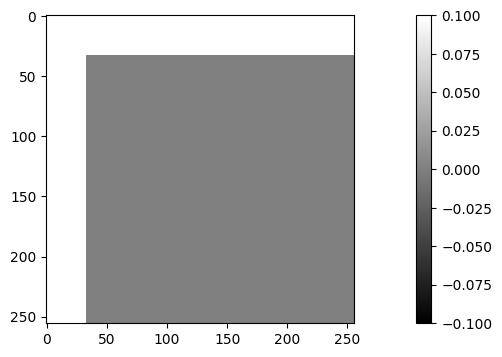

In [10]:
fig = plt.figure(figsize=plt.figaspect(0.25))
slice=128
ax = fig.add_subplot(1, 1, 1)
plt.imshow(grad[:,:,slice],cmap="gray",vmin=torch.min(grad),vmax=torch.max(grad))
plt.colorbar()

#plt.quiver(X_plot,Y_plot,values[:,:,slice,0],values[:,:,slice,1],alpha = 0.5,scale = 0.1)

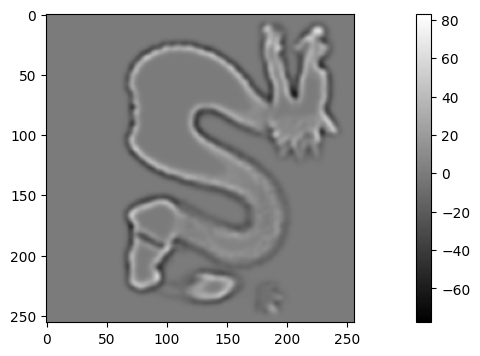

In [95]:
fig = plt.figure(figsize=plt.figaspect(0.25))
slice=128
ax = fig.add_subplot(1, 1, 1)
plt.imshow(grad[:,:,slice],cmap="gray",vmin=torch.min(grad),vmax=torch.max(grad))
plt.colorbar()

#plt.quiver(X_plot,Y_plot,values[:,:,slice,0],values[:,:,slice,1],alpha = 0.5,scale = 0.1)


# List of Gaussian kernels

In [29]:
def get_list_gaussians(borders,D):
    res_centers=torch.empty(8**D,4)

    min_x=borders[0]#.item()
    max_x=borders[1]#.item()
    min_y=borders[2]#.item()
    max_y=borders[3]#.item()
    min_z=borders[4]#.item()
    max_z=borders[5]#.item()

    Width=(max_x-min_x)/(2**D)

    tmp_grid=torch.empty((2**D,2**D,2**D,3))

   
    i=min_x+torch.arange(0,2**D,1)*Width+Width/2.0
    j=min_y+torch.arange(0,2**D,1)*Width+Width/2.0
    w=min_z+torch.arange(0,2**D,1)*Width+Width/2.0


    grid_x, grid_y, grid_z = torch.meshgrid(i, j, w, indexing='ij')

    tmp_grid[:,:,:,0]=grid_x
    tmp_grid[:,:,:,1]=grid_y
    tmp_grid[:,:,:,2]=grid_z

    res_centers[:,0]=tmp_grid[:,:,:,0].flatten()
    res_centers[:,1]=tmp_grid[:,:,:,1].flatten()
    res_centers[:,2]=tmp_grid[:,:,:,2].flatten()
    res_centers[:,3]=Width

    return res_centers

In [33]:

Depth_gauss=6
bord=get_borders(points_c)
L_gaussians=get_list_gaussians(bord,Depth_gauss)
print(L_gaussians.shape)

torch.Size([262144, 4])


# Computation of < B , V >

In [35]:
def get_inner_product_gradVB_new(V,L_gaussians,borders):
    V=V.to(device) 
    L_gaussians=L_gaussians.to(device) 

    
    
    res=torch.empty(L_gaussians.shape[0])

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()

    w_x=max_x-min_x
    w_y=max_y-min_y
    w_z=max_z-min_z

    resolution=V.shape[0]
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)
    
    
    grid_coords=torch.zeros((resolution,resolution,resolution,3)).to(device) 
    

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')
 
    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z

    
    


    for idx_gaussian in tqdm(range(L_gaussians.shape[0])):
        
        tmp_sum_g=((grid_coords[:,:,:,0]-L_gaussians[idx_gaussian,0])/L_gaussians[idx_gaussian,3])**2
        tmp_sum_g+=((grid_coords[:,:,:,1]-L_gaussians[idx_gaussian,1])/L_gaussians[idx_gaussian,3])**2
        tmp_sum_g+=((grid_coords[:,:,:,2]-L_gaussians[idx_gaussian,2])/L_gaussians[idx_gaussian,3])**2
        
        tmp_sum_g=torch.exp(-(tmp_sum_g/(1.5**2)))/L_gaussians[idx_gaussian,3]**3
        
        tmp_sum_g=tmp_sum_g*V
        tmp_sum_g=torch.sum(tmp_sum_g*((w_x*w_y*w_z)/resolution**3))
        res[idx_gaussian]=tmp_sum_g.detach().cpu()

    V=V.detach().cpu()
    L_gaussians=L_gaussians.detach().cpu()
    torch.cuda.empty_cache()
    gc.collect()
        
    
    
        
    return res

def get_inner_product_gradVB_batched(V, L_gaussians, borders, batch_size=32):
    V=V.to(device)
    # Assuming points_c is defined elsewhere and available here
    min_x = torch.min(points_c[:, 0]).item()
    max_x = torch.max(points_c[:, 0]).item()
    min_y = torch.min(points_c[:, 1]).item()
    max_y = torch.max(points_c[:, 1]).item()
    min_z = torch.min(points_c[:, 2]).item()
    max_z = torch.max(points_c[:, 2]).item()

    w_x = max_x - min_x
    w_y = max_y - min_y
    w_z = max_z - min_z

    resolution = V.shape[0]

    x_range = torch.linspace(min_x, max_x, resolution)
    y_range = torch.linspace(min_y, max_y, resolution)
    z_range = torch.linspace(min_z, max_z, resolution)

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')
    
    # Pre-compute the grid coordinates
    grid_coords = torch.stack([grid_x, grid_y, grid_z], dim=-1).to(device)

    res = torch.empty(L_gaussians.shape[0], device=device)
    
    num_batches = (L_gaussians.shape[0] + batch_size - 1) // batch_size

    for b in tqdm(range(num_batches)):
        start_idx = b * batch_size
        end_idx = min((b + 1) * batch_size, L_gaussians.shape[0])
        batch = L_gaussians[start_idx:end_idx].to(device)

        tmp_sum_g = ((grid_coords[..., 0:1] - batch[:, 0:1].T) / batch[:, 3:4].T) ** 2
        tmp_sum_g += ((grid_coords[..., 1:2] - batch[:, 1:2].T) / batch[:, 3:4].T) ** 2
        tmp_sum_g += ((grid_coords[..., 2:3] - batch[:, 2:3].T) / batch[:, 3:4].T) ** 2
        
        tmp_sum_g = torch.exp(-(tmp_sum_g / (1.5 ** 2))) / batch[:, 3:4].T ** 3
        tmp_sum_g = tmp_sum_g * V.unsqueeze(-1)  # Add an extra dimension for broadcasting

        # Sum over the grid dimensions and multiply by volume element
        tmp_sum_g = torch.sum(tmp_sum_g, dim=(0, 1, 2)) * ((w_x * w_y * w_z) / resolution ** 3)
        res[start_idx:end_idx] = tmp_sum_g.detach().cpu()

    # Cleanup
    V = V.detach().cpu()
    L_gaussians = L_gaussians.detach().cpu()
    torch.cuda.empty_cache()
    gc.collect()

    return res

In [ ]:
V_o=get_inner_product_gradVB_batched(grad,L_gaussians,bord)

  0%|                                                                                                                | 0/256 [00:00<?, ?it/s]

# Computation of < B'' , B >

In [15]:
def get_indexes_BB(id_ligne,L_gaussians,D):
    

    tmp_ker=L_gaussians[id_ligne,:]

    tmp_L_g=L_gaussians[id_ligne:id_ligne+15*4**D,:]
    

    tmp_L_g=torch.sqrt(torch.sum((tmp_L_g[:,:3]-tmp_ker[:3])**2,dim=(1)))/tmp_ker[3]
    b= tmp_L_g <=13

    
    return id_ligne+b.nonzero().flatten()

def get_indexes_BB_reverse(id_ligne,L_gaussians,D):
    

    tmp_ker=L_gaussians[id_ligne,:]

    tmp_L_g=L_gaussians[id_ligne-15*4**D:id_ligne,:]
    

    tmp_L_g=torch.sqrt(torch.sum((tmp_L_g[:,:3]-tmp_ker[:3])**2,dim=(1)))/tmp_ker[3]
    b= tmp_L_g <=13

    
    return id_ligne-b.nonzero().flatten()

def get_vec_idxs(L_gaussians,D,reverse=False):
    vec_ixds=torch.empty((0,2))
    
    print("computation of matrix indexes")
    for idx_gaussian_1 in tqdm(range(L_gaussians.shape[0])):
        indexes=None
        if reverse:
            indexes=get_indexes_BB_reverse(idx_gaussian_1,L_gaussians,D)
        else:
            indexes=get_indexes_BB(idx_gaussian_1,L_gaussians,D)
            
        tmp_list=torch.zeros((indexes.shape[0],2))
        tmp_list[:,0]=indexes
        tmp_list[:,1]=idx_gaussian_1
        vec_ixds=torch.cat((vec_ixds,tmp_list),0)

    return vec_ixds


In [16]:
#vec_ixds=get_vec_idxs(L_gaussians,Depth_gauss)

In [17]:
def get_inner_product_gradB_B_sparse_vec(size_grid,vec_ixds, L_gaussians, borders,D):
    
    sparse_indexes = torch.empty((2,0))
    sparse_values  = torch.empty(0)

    
    

    batch_size=512*4



    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()
    min_z=borders[4].item()
    max_z=borders[5].item()

    width_x = max_x - min_x
    width_y = max_y - min_y
    width_z = max_z - min_z

    xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=size_grid)
    ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=size_grid)
    zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=size_grid)
    
    x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

    grid = torch.empty(size_grid, size_grid, size_grid, 3)
    grid[:, :, :, 0] = x
    grid[:, :, :, 1] = y
    grid[:, :, :, 2] = z

    

    
    print("computation of the matrix")
    for batch in tqdm(range(0,vec_ixds.shape[0],batch_size)):

        
        Width=L_gaussians[0,3]
        coords_g1=L_gaussians[vec_ixds[batch:batch+batch_size,1].to(torch.int)].to(device)
        coords_g1=coords_g1[:,:3].unsqueeze(1).unsqueeze(1).unsqueeze(1).expand((-1,size_grid,size_grid,size_grid,-1))
        coords_g2=L_gaussians[vec_ixds[batch:batch+batch_size,0].to(torch.int)].to(device)
        coords_g2=coords_g2[:,:3].unsqueeze(1).unsqueeze(1).unsqueeze(1).expand((-1,size_grid,size_grid,size_grid,-1))

        taille_batch = coords_g2.shape[0]
        grid_tmp= grid.clone().to(device).unsqueeze(0).repeat((taille_batch, 1, 1, 1, 1))

        
        gauss_1=( (grid_tmp.clone()-coords_g1) / Width )**2
        gauss_1= torch.exp(-torch.sum(gauss_1,dim=4)/(1.5**2))
        gauss_1x= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 0]-coords_g1[:, :, :, :, 0])/(1.5**2))/Width**3
        gauss_1y= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 1]-coords_g1[:, :, :, :, 1])/(1.5**2))/Width**3
        gauss_1z= -(gauss_1.clone()*(grid_tmp[:, :, :, :, 2]-coords_g1[:, :, :, :, 2])/(1.5**2))/Width**3

        gauss_2=( (grid_tmp.clone()-coords_g2) / Width )**2
        gauss_2= torch.exp(-torch.sum(gauss_2,dim=4)/(1.5**2))
        gauss_2x= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 0]-coords_g2[:, :, :, :, 0])/(1.5**2)))/Width**3
        gauss_2y= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 1]-coords_g2[:, :, :, :, 1])/(1.5**2)))/Width**3
        gauss_2z= -((gauss_2.clone()*(grid_tmp[:, :, :, :, 2]-coords_g2[:, :, :, :, 2])/(1.5**2)))/Width**3
        

        
        
        tmp_res=-torch.sum(gauss_1x*gauss_2x*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))
        tmp_res+=-torch.sum(gauss_1y*gauss_2y*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))
        tmp_res+=-torch.sum(gauss_1z*gauss_2z*((width_x*width_y*width_z)/size_grid**3),dim=(1,2,3))

        
        sparse_indexes = torch.cat((sparse_indexes,vec_ixds[batch:batch+batch_size].permute(1,0) ), dim=1)
        sparse_values = torch.cat((sparse_values, tmp_res.detach().cpu()), dim=0)

        tmp_vec_idxs_flip=torch.empty(vec_ixds[batch:batch+batch_size].shape)
        tmp_vec_idxs_flip[:,0]=vec_ixds[batch:batch+batch_size,1]
        tmp_vec_idxs_flip[:,1]=vec_ixds[batch:batch+batch_size,0]

        tmp_vec_idxs_flip_boolean=(tmp_vec_idxs_flip[:,0]!=tmp_vec_idxs_flip[:,1]).nonzero()

        tmp_vec_idxs_flip=tmp_vec_idxs_flip[tmp_vec_idxs_flip_boolean,][:,0,:]
       
        tmp_res=tmp_res[tmp_vec_idxs_flip_boolean][:,0]

        sparse_indexes = torch.cat((sparse_indexes,tmp_vec_idxs_flip.permute(1,0) ), dim=1)
        sparse_values = torch.cat((sparse_values, tmp_res.detach().cpu()), dim=0)
        
        
    
        

    
    sparse_indexes=sparse_indexes.detach().cpu()
    sparse_values=sparse_values.detach().cpu()
     
    #np.save("./L_oo/indexes_"+str(D)+".npy",sparse_indexes.numpy().astype(np.single))
    #np.save("./L_oo/values_"+str(D)+".npy",sparse_values.numpy().astype(np.single))
    torch.cuda.empty_cache()
    gc.collect()

    return sparse_indexes,sparse_values#torch.sparse_coo_tensor(sparse_indexes, sparse_values,size=(8**D, 8**D))
        

        
        


    
    return id_ligne+b.nonzero().flatten()

def get_Loo(L_gaussians,D,borders):

    sparse_indexes = torch.empty((2,0))
    sparse_values  = torch.empty(0)
    
    vec_ixds=torch.empty((0,2))
    vec_idx_half=torch.empty((0,2))

    idx_half_start=2**D*2**D*((2**D)/2.0)
    idx_half_end=idx_half_start+4**D

    
    size_grid=32
    
    print("computation of the first slice indexes")
    for idx_gaussian_1 in tqdm(range(4**D)):
        indexes=get_indexes_BB(idx_gaussian_1,L_gaussians,D)
        tmp_list=torch.zeros((indexes.shape[0],2))
        tmp_list[:,0]=indexes
        tmp_list[:,1]=idx_gaussian_1
        vec_idx_half=torch.cat((vec_idx_half,tmp_list),0)

    indexes_half,values_half=get_inner_product_gradB_B_sparse_vec(size_grid,vec_idx_half, L_gaussians, borders,D)
        
    print("replication in the sparse matrix")
    for layer in tqdm(range(0,8**D,4**D)):
        indexes_half_tmp=indexes_half.clone()+layer
        
        mask=(indexes_half_tmp[0] < L_gaussians.shape[0]) & (indexes_half_tmp[1] < L_gaussians.shape[0])
        
        indexes_half_tmp=indexes_half_tmp[:, mask]
        values_half_tmp = values_half.clone()[mask]
        
        
        
        sparse_indexes = torch.cat((sparse_indexes,indexes_half_tmp ), dim=1)
        sparse_values = torch.cat((sparse_values,values_half_tmp), dim=0)
        
        
        
    
    
    
        

    return sparse_indexes,sparse_values




def get_Loo_slice_mini(L_gaussians,D,borders):

    sparse_indexes = torch.empty((2,0))
    sparse_values  = torch.empty(0)
    
    vec_idx_start=torch.empty((0,2))
    
    
    size_grid=64
    
    print("computation of the first slice indexes")
    for idx_gaussian_1 in tqdm(range(4**D)):
        indexes=get_indexes_BB(idx_gaussian_1,L_gaussians,D)
        tmp_list=torch.zeros((indexes.shape[0],2))
        tmp_list[:,0]=indexes
        tmp_list[:,1]=idx_gaussian_1
        vec_idx_start=torch.cat((vec_idx_start,tmp_list),0)

    indexes_start,values_start=get_inner_product_gradB_B_sparse_vec(size_grid,vec_idx_start, L_gaussians, borders,D)

   

    
    mask_h=(indexes_start[0] <= 4**D) 
    mask_v=(indexes_start[1] <= 4**D) 
   
        
    indexes_start_h=indexes_start.clone()[:, mask_h]
    values_start_h= values_start.clone()[mask_h]

    indexes_start_v=indexes_start.clone()[:, mask_v]
    values_start_v= values_start.clone()[mask_v]


    tmp_L_oo=torch.sparse_coo_tensor(indexes_start_h,values_start_h,size=(4**D,15*4**Depth_gauss))
    tmp_L_oo=tmp_L_oo.to_dense()
  
    res=torch.zeros((4**Depth_gauss,25*4**D))
    step=4**D

    
    res[:,12*step:]=tmp_L_oo.clone()[:,:13*4**D]

    tmp_L_oo=torch.sparse_coo_tensor(indexes_start_v,values_start_v,size=(15*4**Depth_gauss,4**D))
    tmp_L_oo=tmp_L_oo.to_dense()

    res[:,11*step:12*step]=tmp_L_oo[step:step*2,:].clone()
    res[:,10*step:11*step]=tmp_L_oo[step*2:step*3,:].clone()
    res[:,9*step:10*step]=tmp_L_oo[step*3:step*4,:].clone()
    res[:,8*step:9*step]=tmp_L_oo[step*4:step*5,:].clone()
    res[:,7*step:8*step]=tmp_L_oo[step*5:step*6,:].clone()
    res[:,6*step:7*step]=tmp_L_oo[step*6:step*7,:].clone()
    res[:,5*step:6*step]=tmp_L_oo[step*7:step*8,:].clone()
    res[:,4*step:5*step]=tmp_L_oo[step*8:step*9,:].clone()
    res[:,3*step:4*step]=tmp_L_oo[step*9:step*10,:].clone()
    res[:,2*step:3*step]=tmp_L_oo[step*10:step*11,:].clone()
    res[:,1*step:2*step]=tmp_L_oo[step*11:step*12,:].clone()
    res[:,0*step:1*step]=tmp_L_oo[step*12:step*13,:].clone()
    
    

    return res





In [18]:
#loo_indexes,loo_values=get_inner_product_gradB_B_sparse_vec(8,vec_ixds, L_gaussians, bord,Depth_gauss)
#loo_indexes,loo_values=get_Loo(L_gaussians,Depth_gauss,bord)

#tmp_L_oo=torch.sparse_coo_tensor(loo_indexes,loo_values,size=(8**Depth_gauss,8**Depth_gauss))

In [19]:
Loo=get_Loo_slice_mini(L_gaussians,Depth_gauss,bord)

computation of the first slice indexes


100%|██████████████████████████████████████| 4096/4096 [00:13<00:00, 298.73it/s]


computation of the matrix


100%|███████████████████████████████████████| 7793/7793 [33:59<00:00,  3.82it/s]


In [21]:
def multiply_lower_space(L_oo,X,D):
    #Loo : [4**D,13*4**D]
    #X   : 8**D
    res=torch.ones(8**D)
    step=4**D
    L_oo=L_oo

    #5
    tmp_X=X.view((X.shape[0],1))
    #X   : 8**D,1
    
    
    #5
    for i in range(0,13):
        tmp_Loo=L_oo[:,(12-i)*step:(12-i)*step+8**D]
        res[step*i:step*(i+1)]=torch.mm(tmp_Loo,tmp_X[:tmp_Loo.shape[1],:]).flatten()

    
        
       

    max_loop=int(8**D/4**D)
    for i in range(13,max_loop-12,1):
        res[step*(i):step*(i+1)]=torch.mm(L_oo,tmp_X[step*(i-12):step*(i-12)+L_oo.shape[1],:]).flatten()

    tmp_Loo=L_oo[:,:(13)*step]
    res[-step:]=torch.mm(tmp_Loo,tmp_X[-tmp_Loo.shape[1]:,:]).flatten()

    for i in range(1,13):
        tmp_Loo=L_oo[:,:(13+i)*step]
        res[-step*(1+i):-step*(i)]=torch.mm(tmp_Loo,tmp_X[-tmp_Loo.shape[1]:,:]).flatten()

    return res
    

    

        

    

# Linear system solving

In [470]:
from scipy.sparse.linalg import cg

def tmp_callback(xk):
    pass

tmp_L_oo=scipy.sparse.coo_matrix((loo_values.numpy(), loo_indexes.numpy()), shape=(8**Depth_gauss, 8**Depth_gauss))
A = csc_matrix(tmp_L_oo)
B=V_o.detach().cpu().numpy()

eps, exit_code = cg(A, B, tol=1e-1)
print(exit_code)

eps=torch.from_numpy(np.array(eps))

0


In [120]:
#grid resolution
n_p=64

min_x=torch.min(points_c[:,0]).item()
max_x=torch.max(points_c[:,0]).item()
min_y=torch.min(points_c[:,1]).item()
max_y=torch.max(points_c[:,1]).item()
min_z=torch.min(points_c[:,2]).item()
max_z=torch.max(points_c[:,2]).item()

width_x=max_x-min_x
width_y=max_y-min_y
width_z=max_y-min_z

image_res=torch.zeros((n_p,n_p,n_p))

xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=n_p)
ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=n_p)
zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=n_p)

x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

grid = torch.empty(n_p, n_p, n_p, 3)
grid[:, :, :, 0] = x
grid[:, :, :, 1] = y
grid[:, :, :, 2] = z


def get_X(x,l_g,q):
    
    #res=torch.sum(torch.exp(-torch.sum(((q-l_g[:,:3])/l_g[0,3])**2)/(1.5**2))*x)
    res=torch.sum(torch.exp((-torch.sum(((q.to(device)-l_g[:,:3]).to(device)/l_g[0,3].to(device))**2,dim=1))/1.5**2)*x)
    
    #res=torch.sum(torch.exp(-( ((q[0] - l_g[:,0])/l_g[:,3])**2 + ((q[1] - l_g[:,1])/l_g[:,3])**2 + ((q[2] - l_g[:,2])/l_g[:,3])**2 ) / l_g[0,3]**2)*x)

    return res
        


L_gaussians=L_gaussians.to(device) 
eps=eps.clone().to(device) 


for i in tqdm(range(xs.shape[0])):
    for j in range(xs.shape[0]):
        #for w in range(xs.shape[0]):
        w=32
        image_res[i,j,w]=get_X(eps,L_gaussians,grid[i,j,w].to(device) ).detach().cpu()

def get_isovalue(eps,l_g,l_p):
     res=torch.zeros(l_p.shape)
     for idx_p in tqdm(range(l_p.shape[0])):
         tmp_p=l_p[idx_p,:3]
         res[idx_p]=get_X(eps,l_g,tmp_p)
     return res.mean()

#iso_val=get_isovalue(eps,L_gaussians,points_c)
print(iso_val)

100%|███████████████████████████████████████████| 64/64 [00:00<00:00, 80.11it/s]

tensor(-1.8585)


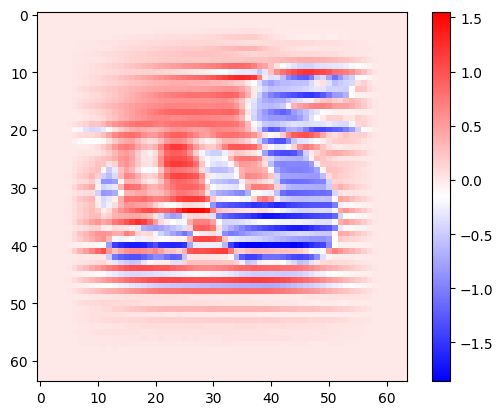

In [122]:
slice=32
plt.imshow(torch.flip(image_res[:,:,slice], dims=[0, 1]),cmap="bwr",vmin=iso_val)
plt.colorbar()

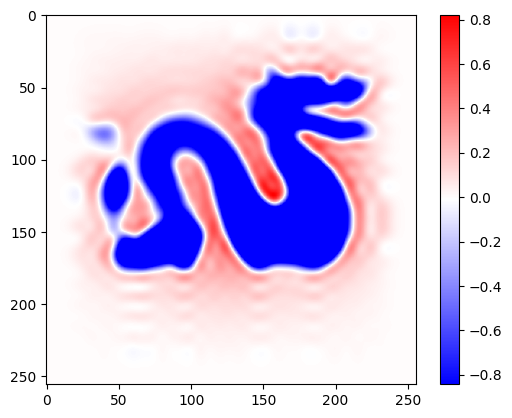

In [168]:
slice=128
plt.imshow(torch.flip(image_res[:,:,slice], dims=[0, 1]),cmap="bwr",vmin=iso_val)
plt.colorbar()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


min_x=torch.min(points_c[:,0]).item()
max_x=torch.max(points_c[:,0]).item()
min_y=torch.min(points_c[:,1]).item()
max_y=torch.max(points_c[:,1]).item()
min_z=torch.min(points_c[:,2]).item()
max_z=torch.max(points_c[:,2]).item()

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(image_res.numpy(),iso_val)


# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 50)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 100)  # b = 10
ax.set_zlim(0, 40)  # c = 16

plt.tight_layout()
plt.show()


NameError: name 'torch' is not defined

In [102]:
def conjugate_gradient(A, b, x=None, tolerance=1e-1, max_iterations=1000):
    
    if x is None:
        x = torch.zeros(b.shape).to(device)
    
    r = b - torch.sparse.mm(A,x.view((x.shape[0],1))).flatten()
    p=r.clone()
    
    
    rs_old = torch.dot(r, r)
    score=999
    for i in tqdm(range(max_iterations)):
        Ap = torch.sparse.mm(A,p.view((p.shape[0],1))).flatten()
        alpha = rs_old / torch.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        
        rs_new = torch.dot(r, r)
        score=torch.sqrt(rs_new)
        if score < tolerance:
            print(score)
            break
        
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    print(score)
    return x

def conjugate_gradient_sliced(A, b,D, x=None, tolerance=1e-1, max_iterations=500):
    
    
    if x is None:
        x = torch.zeros(b.shape)

    b=b
    r = b - multiply_lower_space(A,x,D)
    p=r.clone()
    best=x.clone()
    best_score= None
    
    
    rs_old = torch.dot(r, r)
    score=999
    for i in tqdm(range(max_iterations)):
        Ap = multiply_lower_space(A,p,D)
        alpha = rs_old / torch.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        
        rs_new = torch.dot(r, r)
        
        score=torch.sqrt(torch.mean((multiply_lower_space(A,x,D)-b)**2))

        print(score,"    ",rs_new)
        if best_score!=None and score > 100*best_score:
            print("reset")
            r = b - multiply_lower_space(A,x,D)
            p=r.clone()
            x=best.clone()
            
            continue
       
        if best_score==None or score<best_score:
            best=x.clone()
            best_score=score
            
        
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    print(score,"    best score:", best_score)
    return best,x

In [103]:
V_o=V_o.detach().cpu()
mdr,mdr_3=conjugate_gradient_sliced(Loo,V_o,D=6)

  0%|                                           | 1/500 [00:01<11:43,  1.41s/it]

tensor(10.2101)      tensor(27327524.)


  0%|▏                                          | 2/500 [00:02<11:43,  1.41s/it]

tensor(5.0283)      tensor(6627995.)


  1%|▎                                          | 3/500 [00:04<11:42,  1.41s/it]

tensor(3.3911)      tensor(3014525.5000)


  1%|▎                                          | 4/500 [00:05<11:42,  1.42s/it]

tensor(2.4905)      tensor(1625913.2500)


  1%|▍                                          | 5/500 [00:07<11:41,  1.42s/it]

tensor(2.0079)      tensor(1056836.8750)


  1%|▌                                          | 6/500 [00:08<11:39,  1.42s/it]

tensor(1.6723)      tensor(733091.7500)


  1%|▌                                          | 7/500 [00:09<11:38,  1.42s/it]

tensor(1.4371)      tensor(541399.6875)


  2%|▋                                          | 8/500 [00:11<11:37,  1.42s/it]

tensor(1.2782)      tensor(428296.2500)


  2%|▊                                          | 9/500 [00:12<11:35,  1.42s/it]

tensor(1.1814)      tensor(365889.2500)


  2%|▊                                         | 10/500 [00:14<11:34,  1.42s/it]

tensor(1.1408)      tensor(341139.3438)


  2%|▉                                         | 11/500 [00:15<11:32,  1.42s/it]

tensor(1.0929)      tensor(313131.3438)


  2%|█                                         | 12/500 [00:16<11:31,  1.42s/it]

tensor(1.0992)      tensor(316760.0625)


  3%|█                                         | 13/500 [00:18<11:30,  1.42s/it]

tensor(1.1239)      tensor(331125.9688)


  3%|█▏                                        | 14/500 [00:19<11:28,  1.42s/it]

tensor(1.1471)      tensor(344963.8750)


  3%|█▎                                        | 15/500 [00:21<11:27,  1.42s/it]

tensor(1.1850)      tensor(368089.4688)


  3%|█▎                                        | 16/500 [00:22<11:25,  1.42s/it]

tensor(1.2333)      tensor(398755.9062)


  3%|█▍                                        | 17/500 [00:24<11:24,  1.42s/it]

tensor(1.2696)      tensor(422556.3750)


  4%|█▌                                        | 18/500 [00:25<11:22,  1.42s/it]

tensor(1.2667)      tensor(420589.1875)


  4%|█▌                                        | 19/500 [00:26<11:21,  1.42s/it]

tensor(1.2703)      tensor(422990.6250)


  4%|█▋                                        | 20/500 [00:28<11:20,  1.42s/it]

tensor(1.3713)      tensor(492976.2500)


  4%|█▊                                        | 21/500 [00:29<11:18,  1.42s/it]

tensor(1.4681)      tensor(565008.8125)


  4%|█▊                                        | 22/500 [00:31<11:17,  1.42s/it]

tensor(1.4941)      tensor(585172.1250)


  5%|█▉                                        | 23/500 [00:32<11:16,  1.42s/it]

tensor(1.4567)      tensor(556270.8750)


  5%|██                                        | 24/500 [00:34<11:14,  1.42s/it]

tensor(1.3797)      tensor(499002.5625)


  5%|██                                        | 25/500 [00:35<11:13,  1.42s/it]

tensor(1.3284)      tensor(462616.2188)


  5%|██▏                                       | 26/500 [00:36<11:12,  1.42s/it]

tensor(1.2526)      tensor(411315.4062)


  5%|██▎                                       | 27/500 [00:38<11:10,  1.42s/it]

tensor(1.2209)      tensor(390781.5938)


  6%|██▎                                       | 28/500 [00:39<11:08,  1.42s/it]

tensor(1.2457)      tensor(406782.7500)


  6%|██▍                                       | 29/500 [00:41<11:07,  1.42s/it]

tensor(1.2469)      tensor(407545.4375)


  6%|██▌                                       | 30/500 [00:42<11:06,  1.42s/it]

tensor(1.2310)      tensor(397225.2188)


  6%|██▌                                       | 31/500 [00:43<11:04,  1.42s/it]

tensor(1.2487)      tensor(408746.9062)


  6%|██▋                                       | 32/500 [00:45<11:03,  1.42s/it]

tensor(1.1858)      tensor(368593.8750)


  7%|██▊                                       | 33/500 [00:46<11:01,  1.42s/it]

tensor(1.1309)      tensor(335259.6250)


  7%|██▊                                       | 34/500 [00:48<11:00,  1.42s/it]

tensor(1.1243)      tensor(331387.8750)


  7%|██▉                                       | 35/500 [00:49<10:59,  1.42s/it]

tensor(1.0977)      tensor(315872.4688)


  7%|███                                       | 36/500 [00:51<10:57,  1.42s/it]

tensor(1.0447)      tensor(286119.0938)


  7%|███                                       | 37/500 [00:52<10:56,  1.42s/it]

tensor(1.0279)      tensor(276996.2812)


  8%|███▏                                      | 38/500 [00:53<10:54,  1.42s/it]

tensor(1.0211)      tensor(273336.7500)


  8%|███▎                                      | 39/500 [00:55<10:53,  1.42s/it]

tensor(1.0512)      tensor(289662.6875)


  8%|███▎                                      | 40/500 [00:56<10:51,  1.42s/it]

tensor(1.0670)      tensor(298459.1250)


  8%|███▍                                      | 41/500 [00:58<10:50,  1.42s/it]

tensor(1.0518)      tensor(289996.3125)


  8%|███▌                                      | 42/500 [00:59<10:48,  1.42s/it]

tensor(1.0371)      tensor(281957.3750)


  9%|███▌                                      | 43/500 [01:00<10:47,  1.42s/it]

tensor(1.0086)      tensor(266659.6875)


  9%|███▋                                      | 44/500 [01:02<10:45,  1.42s/it]

tensor(1.0436)      tensor(285507.8125)


  9%|███▊                                      | 45/500 [01:03<10:44,  1.42s/it]

tensor(1.1136)      tensor(325077.7500)


  9%|███▊                                      | 46/500 [01:05<10:42,  1.42s/it]

tensor(1.1414)      tensor(341528.6250)


  9%|███▉                                      | 47/500 [01:06<10:41,  1.42s/it]

tensor(1.1440)      tensor(343106.2812)


 10%|████                                      | 48/500 [01:08<10:40,  1.42s/it]

tensor(1.1181)      tensor(327716.1250)


 10%|████                                      | 49/500 [01:09<10:38,  1.42s/it]

tensor(1.0834)      tensor(307708.4062)


 10%|████▏                                     | 50/500 [01:10<10:37,  1.42s/it]

tensor(1.0780)      tensor(304611.0625)


 10%|████▎                                     | 51/500 [01:12<10:35,  1.42s/it]

tensor(1.0790)      tensor(305220.8750)


 10%|████▎                                     | 52/500 [01:13<10:34,  1.42s/it]

tensor(1.0762)      tensor(303632.3125)


 11%|████▍                                     | 53/500 [01:15<10:33,  1.42s/it]

tensor(1.0687)      tensor(299415.4375)


 11%|████▌                                     | 54/500 [01:16<10:31,  1.42s/it]

tensor(1.0965)      tensor(315163.5938)


 11%|████▌                                     | 55/500 [01:17<10:30,  1.42s/it]

tensor(1.0880)      tensor(310315.7188)


 11%|████▋                                     | 56/500 [01:19<10:28,  1.42s/it]

tensor(1.1350)      tensor(337709.0625)


 11%|████▊                                     | 57/500 [01:20<10:27,  1.42s/it]

tensor(1.1086)      tensor(322188.7188)


 12%|████▊                                     | 58/500 [01:22<10:26,  1.42s/it]

tensor(1.0854)      tensor(308820.5625)


 12%|████▉                                     | 59/500 [01:23<10:24,  1.42s/it]

tensor(1.0678)      tensor(298921.1562)


 12%|█████                                     | 60/500 [01:25<10:23,  1.42s/it]

tensor(1.0083)      tensor(266498.2500)


 12%|█████                                     | 61/500 [01:26<10:22,  1.42s/it]

tensor(0.9503)      tensor(236741.3594)


 12%|█████▏                                    | 62/500 [01:27<10:20,  1.42s/it]

tensor(0.9578)      tensor(240467.0625)


 13%|█████▎                                    | 63/500 [01:29<10:19,  1.42s/it]

tensor(0.9763)      tensor(249867.0781)


 13%|█████▍                                    | 64/500 [01:30<10:17,  1.42s/it]

tensor(0.9526)      tensor(237859.1406)


 13%|█████▍                                    | 65/500 [01:32<10:16,  1.42s/it]

tensor(0.9397)      tensor(231480.3594)


 13%|█████▌                                    | 66/500 [01:33<10:14,  1.42s/it]

tensor(0.9086)      tensor(216411.5156)


 13%|█████▋                                    | 67/500 [01:34<10:13,  1.42s/it]

tensor(0.8900)      tensor(207631.5469)


 14%|█████▋                                    | 68/500 [01:36<10:11,  1.42s/it]

tensor(0.8755)      tensor(200946.2031)


 14%|█████▊                                    | 69/500 [01:37<10:10,  1.42s/it]

tensor(0.8744)      tensor(200429.8594)


 14%|█████▉                                    | 70/500 [01:39<10:08,  1.42s/it]

tensor(0.9263)      tensor(224911.9219)


 14%|█████▉                                    | 71/500 [01:40<10:07,  1.42s/it]

tensor(0.9205)      tensor(222101.3906)


 14%|██████                                    | 72/500 [01:41<10:06,  1.42s/it]

tensor(0.8786)      tensor(202379.3906)


 15%|██████▏                                   | 73/500 [01:43<10:04,  1.42s/it]

tensor(0.8534)      tensor(190899.1875)


 15%|██████▏                                   | 74/500 [01:44<10:03,  1.42s/it]

tensor(0.8693)      tensor(198076.1719)


 15%|██████▎                                   | 75/500 [01:46<10:01,  1.42s/it]

tensor(0.8439)      tensor(186704.5156)


 15%|██████▍                                   | 76/500 [01:47<10:00,  1.42s/it]

tensor(0.8156)      tensor(174379.0156)


 15%|██████▍                                   | 77/500 [01:49<09:59,  1.42s/it]

tensor(0.8429)      tensor(186255.8906)


 16%|██████▌                                   | 78/500 [01:50<09:57,  1.42s/it]

tensor(0.8675)      tensor(197271.6094)


 16%|██████▋                                   | 79/500 [01:51<09:55,  1.42s/it]

tensor(0.8396)      tensor(184772.7812)


 16%|██████▋                                   | 80/500 [01:53<09:54,  1.42s/it]

tensor(0.8642)      tensor(195782.1094)


 16%|██████▊                                   | 81/500 [01:54<09:53,  1.42s/it]

tensor(0.9042)      tensor(214322.6875)


 16%|██████▉                                   | 82/500 [01:56<09:51,  1.42s/it]

tensor(0.9233)      tensor(223464.7812)


 17%|██████▉                                   | 83/500 [01:57<09:50,  1.42s/it]

tensor(0.8941)      tensor(209552.2969)


 17%|███████                                   | 84/500 [01:58<09:49,  1.42s/it]

tensor(0.8681)      tensor(197534.0312)


 17%|███████▏                                  | 85/500 [02:00<09:47,  1.42s/it]

tensor(0.8268)      tensor(179221.4062)


 17%|███████▏                                  | 86/500 [02:01<09:46,  1.42s/it]

tensor(0.8393)      tensor(184648.8750)


 17%|███████▎                                  | 87/500 [02:03<09:44,  1.41s/it]

tensor(0.8522)      tensor(190359.1719)


 18%|███████▍                                  | 88/500 [02:04<09:42,  1.41s/it]

tensor(0.8600)      tensor(193865.7500)


 18%|███████▍                                  | 89/500 [02:06<09:40,  1.41s/it]

tensor(0.8434)      tensor(186478.9844)


 18%|███████▌                                  | 90/500 [02:07<09:39,  1.41s/it]

tensor(0.8170)      tensor(174995.7656)


 18%|███████▋                                  | 91/500 [02:08<09:37,  1.41s/it]

tensor(0.8212)      tensor(176794.7188)


 18%|███████▋                                  | 92/500 [02:10<09:35,  1.41s/it]

tensor(0.8078)      tensor(171058.2344)


 19%|███████▊                                  | 93/500 [02:11<09:34,  1.41s/it]

tensor(0.7984)      tensor(167116.0625)


 19%|███████▉                                  | 94/500 [02:13<09:33,  1.41s/it]

tensor(0.7964)      tensor(166245.7656)


 19%|███████▉                                  | 95/500 [02:14<09:31,  1.41s/it]

tensor(0.8303)      tensor(180703.9219)


 19%|████████                                  | 96/500 [02:15<09:30,  1.41s/it]

tensor(0.7989)      tensor(167307.8750)


 19%|████████▏                                 | 97/500 [02:17<09:28,  1.41s/it]

tensor(0.7774)      tensor(158429.0312)


 20%|████████▏                                 | 98/500 [02:18<09:27,  1.41s/it]

tensor(0.7595)      tensor(151219.4688)


 20%|████████▎                                 | 99/500 [02:20<09:25,  1.41s/it]

tensor(0.7708)      tensor(155768.6875)


 20%|████████▏                                | 100/500 [02:21<09:24,  1.41s/it]

tensor(0.7570)      tensor(150236.6719)


 20%|████████▎                                | 101/500 [02:22<09:23,  1.41s/it]

tensor(0.7090)      tensor(131776.5938)


 20%|████████▎                                | 102/500 [02:24<09:21,  1.41s/it]

tensor(0.7188)      tensor(135448.7969)


 21%|████████▍                                | 103/500 [02:25<09:20,  1.41s/it]

tensor(0.7335)      tensor(141028.7500)


 21%|████████▌                                | 104/500 [02:27<09:18,  1.41s/it]

tensor(0.7347)      tensor(141484.9219)


 21%|████████▌                                | 105/500 [02:28<09:17,  1.41s/it]

tensor(0.7560)      tensor(149829.1094)


 21%|████████▋                                | 106/500 [02:30<09:15,  1.41s/it]

tensor(0.7662)      tensor(153909.5781)


 21%|████████▊                                | 107/500 [02:31<09:14,  1.41s/it]

tensor(0.7491)      tensor(147091.1250)


 22%|████████▊                                | 108/500 [02:32<09:13,  1.41s/it]

tensor(0.7487)      tensor(146950.4688)


 22%|████████▉                                | 109/500 [02:34<09:11,  1.41s/it]

tensor(0.7269)      tensor(138512.3906)


 22%|█████████                                | 110/500 [02:35<09:10,  1.41s/it]

tensor(0.7316)      tensor(140298.9375)


 22%|█████████                                | 111/500 [02:37<09:08,  1.41s/it]

tensor(0.7484)      tensor(146822.)


 22%|█████████▏                               | 112/500 [02:38<09:07,  1.41s/it]

tensor(0.7225)      tensor(136842.8750)


 23%|█████████▎                               | 113/500 [02:39<09:05,  1.41s/it]

tensor(0.7390)      tensor(143154.9062)


 23%|█████████▎                               | 114/500 [02:41<09:04,  1.41s/it]

tensor(0.7624)      tensor(152358.0781)


 23%|█████████▍                               | 115/500 [02:42<09:02,  1.41s/it]

tensor(0.7476)      tensor(146494.3594)


 23%|█████████▌                               | 116/500 [02:44<09:01,  1.41s/it]

tensor(0.7363)      tensor(142113.3594)


 23%|█████████▌                               | 117/500 [02:45<09:00,  1.41s/it]

tensor(0.7414)      tensor(144083.4844)


 24%|█████████▋                               | 118/500 [02:46<08:58,  1.41s/it]

tensor(0.7506)      tensor(147683.6875)


 24%|█████████▊                               | 119/500 [02:48<08:57,  1.41s/it]

tensor(0.7678)      tensor(154525.2969)


 24%|█████████▊                               | 120/500 [02:49<08:56,  1.41s/it]

tensor(0.7619)      tensor(152176.9844)


 24%|█████████▉                               | 121/500 [02:51<08:54,  1.41s/it]

tensor(0.7455)      tensor(145710.1094)


 24%|██████████                               | 122/500 [02:52<08:53,  1.41s/it]

tensor(0.7344)      tensor(141381.6406)


 25%|██████████                               | 123/500 [02:54<08:52,  1.41s/it]

tensor(0.7340)      tensor(141214.5156)


 25%|██████████▏                              | 124/500 [02:55<08:50,  1.41s/it]

tensor(0.7358)      tensor(141938.7500)


 25%|██████████▎                              | 125/500 [02:56<08:49,  1.41s/it]

tensor(0.7168)      tensor(134679.6875)


 25%|██████████▎                              | 126/500 [02:58<08:48,  1.41s/it]

tensor(0.6865)      tensor(123541.6953)


 25%|██████████▍                              | 127/500 [02:59<08:47,  1.41s/it]

tensor(0.6835)      tensor(122473.1094)


 26%|██████████▍                              | 128/500 [03:01<08:45,  1.41s/it]

tensor(0.6782)      tensor(120583.4609)


 26%|██████████▌                              | 129/500 [03:02<08:44,  1.41s/it]

tensor(0.6960)      tensor(127000.6250)


 26%|██████████▋                              | 130/500 [03:03<08:42,  1.41s/it]

tensor(0.7096)      tensor(131989.4531)


 26%|██████████▋                              | 131/500 [03:05<08:41,  1.41s/it]

tensor(0.6929)      tensor(125869.7734)


 26%|██████████▊                              | 132/500 [03:06<08:39,  1.41s/it]

tensor(0.6763)      tensor(119912.5938)


 27%|██████████▉                              | 133/500 [03:08<08:38,  1.41s/it]

tensor(0.6602)      tensor(114256.3672)


 27%|██████████▉                              | 134/500 [03:09<08:36,  1.41s/it]

tensor(0.6520)      tensor(111455.5469)


 27%|███████████                              | 135/500 [03:10<08:35,  1.41s/it]

tensor(0.6364)      tensor(106183.0312)


 27%|███████████▏                             | 136/500 [03:12<08:34,  1.41s/it]

tensor(0.6324)      tensor(104842.5234)


 27%|███████████▏                             | 137/500 [03:13<08:33,  1.41s/it]

tensor(0.6418)      tensor(107990.8828)


 28%|███████████▎                             | 138/500 [03:15<08:31,  1.41s/it]

tensor(0.6291)      tensor(103747.1641)


 28%|███████████▍                             | 139/500 [03:16<08:30,  1.41s/it]

tensor(0.6071)      tensor(96614.6484)


 28%|███████████▍                             | 140/500 [03:18<08:29,  1.41s/it]

tensor(0.6258)      tensor(102656.4375)


 28%|███████████▌                             | 141/500 [03:19<08:28,  1.42s/it]

tensor(0.6295)      tensor(103879.8281)


 28%|███████████▋                             | 142/500 [03:20<08:26,  1.41s/it]

tensor(0.6516)      tensor(111318.9297)


 29%|███████████▋                             | 143/500 [03:22<08:25,  1.41s/it]

tensor(0.6296)      tensor(103924.2812)


 29%|███████████▊                             | 144/500 [03:23<08:23,  1.41s/it]

tensor(0.6138)      tensor(98753.2578)


 29%|███████████▉                             | 145/500 [03:25<08:22,  1.41s/it]

tensor(0.6279)      tensor(103365.8281)


 29%|███████████▉                             | 146/500 [03:26<08:20,  1.41s/it]

tensor(0.6498)      tensor(110687.3750)


 29%|████████████                             | 147/500 [03:27<08:19,  1.41s/it]

tensor(0.6333)      tensor(105125.5625)


 30%|████████████▏                            | 148/500 [03:29<08:17,  1.41s/it]

tensor(0.6278)      tensor(103308.4062)


 30%|████████████▏                            | 149/500 [03:30<08:16,  1.41s/it]

tensor(0.6315)      tensor(104534.9375)


 30%|████████████▎                            | 150/500 [03:32<08:15,  1.41s/it]

tensor(0.6169)      tensor(99771.2969)


 30%|████████████▍                            | 151/500 [03:33<08:13,  1.41s/it]

tensor(0.6091)      tensor(97249.5469)


 30%|████████████▍                            | 152/500 [03:35<08:12,  1.41s/it]

tensor(0.6323)      tensor(104808.7188)


 31%|████████████▌                            | 153/500 [03:36<08:10,  1.41s/it]

tensor(0.6315)      tensor(104525.7266)


 31%|████████████▋                            | 154/500 [03:37<08:09,  1.41s/it]

tensor(0.6354)      tensor(105832.3047)


 31%|████████████▋                            | 155/500 [03:39<08:07,  1.41s/it]

tensor(0.6363)      tensor(106122.3281)


 31%|████████████▊                            | 156/500 [03:40<08:06,  1.41s/it]

tensor(0.6530)      tensor(111784.9297)


 31%|████████████▊                            | 157/500 [03:42<08:05,  1.41s/it]

tensor(0.6291)      tensor(103733.3906)


 32%|████████████▉                            | 158/500 [03:43<08:03,  1.41s/it]

tensor(0.6088)      tensor(97162.6641)


 32%|█████████████                            | 159/500 [03:44<08:02,  1.41s/it]

tensor(0.6120)      tensor(98190.8281)


 32%|█████████████                            | 160/500 [03:46<08:00,  1.41s/it]

tensor(0.6016)      tensor(94887.0312)


 32%|█████████████▏                           | 161/500 [03:47<07:59,  1.41s/it]

tensor(0.5964)      tensor(93252.6719)


 32%|█████████████▎                           | 162/500 [03:49<07:57,  1.41s/it]

tensor(0.5851)      tensor(89733.5938)


 33%|█████████████▎                           | 163/500 [03:50<07:56,  1.41s/it]

tensor(0.5817)      tensor(88687.2344)


 33%|█████████████▍                           | 164/500 [03:52<07:54,  1.41s/it]

tensor(0.5667)      tensor(84191.5781)


 33%|█████████████▌                           | 165/500 [03:53<07:53,  1.41s/it]

tensor(0.5773)      tensor(87373.5859)


 33%|█████████████▌                           | 166/500 [03:54<07:52,  1.41s/it]

tensor(0.5853)      tensor(89813.4062)


 33%|█████████████▋                           | 167/500 [03:56<07:50,  1.41s/it]

tensor(0.5694)      tensor(84991.5391)


 34%|█████████████▊                           | 168/500 [03:57<07:49,  1.41s/it]

tensor(0.5648)      tensor(83623.3516)


 34%|█████████████▊                           | 169/500 [03:59<07:47,  1.41s/it]

tensor(0.5552)      tensor(80807.5938)


 34%|█████████████▉                           | 170/500 [04:00<07:46,  1.41s/it]

tensor(0.5476)      tensor(78613.4531)


 34%|██████████████                           | 171/500 [04:01<07:44,  1.41s/it]

tensor(0.5514)      tensor(79712.0469)


 34%|██████████████                           | 172/500 [04:03<07:43,  1.41s/it]

tensor(0.5482)      tensor(78788.2344)


 35%|██████████████▏                          | 173/500 [04:04<07:42,  1.41s/it]

tensor(0.5335)      tensor(74606.8359)


 35%|██████████████▎                          | 174/500 [04:06<07:41,  1.41s/it]

tensor(0.5337)      tensor(74676.8281)


 35%|██████████████▎                          | 175/500 [04:07<07:39,  1.41s/it]

tensor(0.5216)      tensor(71310.3047)


 35%|██████████████▍                          | 176/500 [04:08<07:38,  1.42s/it]

tensor(0.5173)      tensor(70142.5391)


 35%|██████████████▌                          | 177/500 [04:10<07:38,  1.42s/it]

tensor(0.5081)      tensor(67673.8906)


 36%|██████████████▌                          | 178/500 [04:11<07:36,  1.42s/it]

tensor(0.5402)      tensor(76488.9062)


 36%|██████████████▋                          | 179/500 [04:13<07:44,  1.45s/it]

tensor(0.5346)      tensor(74910.6016)


 36%|██████████████▊                          | 180/500 [04:14<07:40,  1.44s/it]

tensor(0.5192)      tensor(70665.6719)


 36%|██████████████▊                          | 181/500 [04:16<07:37,  1.43s/it]

tensor(0.5196)      tensor(70771.1172)


 36%|██████████████▉                          | 182/500 [04:17<07:34,  1.43s/it]

tensor(0.5226)      tensor(71582.2344)


 37%|███████████████                          | 183/500 [04:19<07:32,  1.43s/it]

tensor(0.5271)      tensor(72827.4688)


 37%|███████████████                          | 184/500 [04:20<07:30,  1.42s/it]

tensor(0.5171)      tensor(70086.2969)


 37%|███████████████▏                         | 185/500 [04:21<07:28,  1.42s/it]

tensor(0.5124)      tensor(68827.1719)


 37%|███████████████▎                         | 186/500 [04:23<07:26,  1.42s/it]

tensor(0.4951)      tensor(64245.7070)


 37%|███████████████▎                         | 187/500 [04:24<07:24,  1.42s/it]

tensor(0.4941)      tensor(64000.6484)


 38%|███████████████▍                         | 188/500 [04:26<07:23,  1.42s/it]

tensor(0.5013)      tensor(65872.6953)


 38%|███████████████▍                         | 189/500 [04:27<07:21,  1.42s/it]

tensor(0.5026)      tensor(66221.6875)


 38%|███████████████▌                         | 190/500 [04:28<07:20,  1.42s/it]

tensor(0.4972)      tensor(64807.3125)


 38%|███████████████▋                         | 191/500 [04:30<07:19,  1.42s/it]

tensor(0.5021)      tensor(66099.6250)


 38%|███████████████▋                         | 192/500 [04:31<07:17,  1.42s/it]

tensor(0.4961)      tensor(64526.6914)


 39%|███████████████▊                         | 193/500 [04:33<07:16,  1.42s/it]

tensor(0.4932)      tensor(63754.2617)


 39%|███████████████▉                         | 194/500 [04:34<07:14,  1.42s/it]

tensor(0.4861)      tensor(61953.4219)


 39%|███████████████▉                         | 195/500 [04:36<07:12,  1.42s/it]

tensor(0.4846)      tensor(61566.4961)


 39%|████████████████                         | 196/500 [04:37<07:11,  1.42s/it]

tensor(0.4825)      tensor(61020.8242)


 39%|████████████████▏                        | 197/500 [04:38<07:10,  1.42s/it]

tensor(0.4743)      tensor(58966.7305)


 40%|████████████████▏                        | 198/500 [04:40<07:08,  1.42s/it]

tensor(0.4666)      tensor(57084.4648)


 40%|████████████████▎                        | 199/500 [04:41<07:07,  1.42s/it]

tensor(0.4657)      tensor(56849.8477)


 40%|████████████████▍                        | 200/500 [04:43<07:05,  1.42s/it]

tensor(0.4484)      tensor(52716.7656)


 40%|████████████████▍                        | 201/500 [04:44<07:04,  1.42s/it]

tensor(0.4522)      tensor(53595.0391)


 40%|████████████████▌                        | 202/500 [04:45<07:02,  1.42s/it]

tensor(0.4541)      tensor(54062.6484)


 41%|████████████████▋                        | 203/500 [04:47<07:01,  1.42s/it]

tensor(0.4509)      tensor(53290.8594)


 41%|████████████████▋                        | 204/500 [04:48<07:00,  1.42s/it]

tensor(0.4529)      tensor(53779.2852)


 41%|████████████████▊                        | 205/500 [04:50<06:58,  1.42s/it]

tensor(0.4508)      tensor(53279.7148)


 41%|████████████████▉                        | 206/500 [04:51<06:57,  1.42s/it]

tensor(0.4479)      tensor(52582.9336)


 41%|████████████████▉                        | 207/500 [04:53<06:55,  1.42s/it]

tensor(0.4482)      tensor(52655.2422)


 42%|█████████████████                        | 208/500 [04:54<06:54,  1.42s/it]

tensor(0.4371)      tensor(50087.6992)


 42%|█████████████████▏                       | 209/500 [04:55<06:52,  1.42s/it]

tensor(0.4283)      tensor(48083.3750)


 42%|█████████████████▏                       | 210/500 [04:57<06:51,  1.42s/it]

tensor(0.4365)      tensor(49940.5586)


 42%|█████████████████▎                       | 211/500 [04:58<06:50,  1.42s/it]

tensor(0.4261)      tensor(47590.2422)


 42%|█████████████████▍                       | 212/500 [05:00<06:48,  1.42s/it]

tensor(0.4229)      tensor(46883.6914)


 43%|█████████████████▍                       | 213/500 [05:01<06:47,  1.42s/it]

tensor(0.4368)      tensor(50026.8633)


 43%|█████████████████▌                       | 214/500 [05:03<06:45,  1.42s/it]

tensor(0.4387)      tensor(50452.1562)


 43%|█████████████████▋                       | 215/500 [05:04<06:44,  1.42s/it]

tensor(0.4261)      tensor(47594.6133)


 43%|█████████████████▋                       | 216/500 [05:05<06:42,  1.42s/it]

tensor(0.4391)      tensor(50552.9180)


 43%|█████████████████▊                       | 217/500 [05:07<06:41,  1.42s/it]

tensor(0.4380)      tensor(50301.7773)


 44%|█████████████████▉                       | 218/500 [05:08<06:40,  1.42s/it]

tensor(0.4320)      tensor(48929.3125)


 44%|█████████████████▉                       | 219/500 [05:10<06:38,  1.42s/it]

tensor(0.4353)      tensor(49673.7656)


 44%|██████████████████                       | 220/500 [05:11<06:37,  1.42s/it]

tensor(0.4360)      tensor(49835.5430)


 44%|██████████████████                       | 221/500 [05:12<06:35,  1.42s/it]

tensor(0.4350)      tensor(49596.5234)


 44%|██████████████████▏                      | 222/500 [05:14<06:34,  1.42s/it]

tensor(0.4219)      tensor(46660.5430)


 45%|██████████████████▎                      | 223/500 [05:15<06:33,  1.42s/it]

tensor(0.4166)      tensor(45489.0078)


 45%|██████████████████▎                      | 224/500 [05:17<06:31,  1.42s/it]

tensor(0.4230)      tensor(46895.3320)


 45%|██████████████████▍                      | 225/500 [05:18<06:30,  1.42s/it]

tensor(0.4233)      tensor(46982.8477)


 45%|██████████████████▌                      | 226/500 [05:20<06:28,  1.42s/it]

tensor(0.4239)      tensor(47108.2695)


 45%|██████████████████▌                      | 227/500 [05:21<06:27,  1.42s/it]

tensor(0.4222)      tensor(46735.7500)


 46%|██████████████████▋                      | 228/500 [05:22<06:25,  1.42s/it]

tensor(0.4166)      tensor(45501.6445)


 46%|██████████████████▊                      | 229/500 [05:24<06:24,  1.42s/it]

tensor(0.4124)      tensor(44584.7109)


 46%|██████████████████▊                      | 230/500 [05:25<06:22,  1.42s/it]

tensor(0.4233)      tensor(46967.8477)


 46%|██████████████████▉                      | 231/500 [05:27<06:21,  1.42s/it]

tensor(0.4236)      tensor(47032.8633)


 46%|███████████████████                      | 232/500 [05:28<06:20,  1.42s/it]

tensor(0.4194)      tensor(46113.0117)


 47%|███████████████████                      | 233/500 [05:29<06:18,  1.42s/it]

tensor(0.4092)      tensor(43901.0625)


 47%|███████████████████▏                     | 234/500 [05:31<06:17,  1.42s/it]

tensor(0.4021)      tensor(42382.4609)


 47%|███████████████████▎                     | 235/500 [05:32<06:15,  1.42s/it]

tensor(0.3945)      tensor(40792.3750)


 47%|███████████████████▎                     | 236/500 [05:34<06:14,  1.42s/it]

tensor(0.3976)      tensor(41449.8906)


 47%|███████████████████▍                     | 237/500 [05:35<06:13,  1.42s/it]

tensor(0.3967)      tensor(41259.2617)


 48%|███████████████████▌                     | 238/500 [05:37<06:11,  1.42s/it]

tensor(0.3969)      tensor(41285.8203)


 48%|███████████████████▌                     | 239/500 [05:38<06:10,  1.42s/it]

tensor(0.3997)      tensor(41884.5547)


 48%|███████████████████▋                     | 240/500 [05:39<06:08,  1.42s/it]

tensor(0.3955)      tensor(41011.8398)


 48%|███████████████████▊                     | 241/500 [05:41<06:07,  1.42s/it]

tensor(0.3967)      tensor(41244.6797)


 48%|███████████████████▊                     | 242/500 [05:42<06:06,  1.42s/it]

tensor(0.3937)      tensor(40627.0195)


 49%|███████████████████▉                     | 243/500 [05:44<06:04,  1.42s/it]

tensor(0.3953)      tensor(40955.1602)


 49%|████████████████████                     | 244/500 [05:45<06:03,  1.42s/it]

tensor(0.3845)      tensor(38763.9219)


 49%|████████████████████                     | 245/500 [05:46<06:01,  1.42s/it]

tensor(0.3947)      tensor(40829.7539)


 49%|████████████████████▏                    | 246/500 [05:48<05:59,  1.42s/it]

tensor(0.3877)      tensor(39394.4492)


 49%|████████████████████▎                    | 247/500 [05:49<05:58,  1.42s/it]

tensor(0.3766)      tensor(37173.0742)


 50%|████████████████████▎                    | 248/500 [05:51<05:57,  1.42s/it]

tensor(0.3755)      tensor(36963.6445)


 50%|████████████████████▍                    | 249/500 [05:52<05:55,  1.42s/it]

tensor(0.3869)      tensor(39250.0859)


 50%|████████████████████▌                    | 250/500 [05:54<05:54,  1.42s/it]

tensor(0.3898)      tensor(39835.3828)


 50%|████████████████████▌                    | 251/500 [05:55<05:52,  1.42s/it]

tensor(0.3860)      tensor(39059.4688)


 50%|████████████████████▋                    | 252/500 [05:56<05:51,  1.42s/it]

tensor(0.3814)      tensor(38135.8672)


 51%|████████████████████▋                    | 253/500 [05:58<05:49,  1.42s/it]

tensor(0.3833)      tensor(38521.5039)


 51%|████████████████████▊                    | 254/500 [05:59<05:48,  1.42s/it]

tensor(0.3895)      tensor(39766.5938)


 51%|████████████████████▉                    | 255/500 [06:01<05:46,  1.42s/it]

tensor(0.3807)      tensor(38002.5312)


 51%|████████████████████▉                    | 256/500 [06:02<05:45,  1.42s/it]

tensor(0.3872)      tensor(39300.4102)


 51%|█████████████████████                    | 257/500 [06:03<05:44,  1.42s/it]

tensor(0.3930)      tensor(40481.7422)


 52%|█████████████████████▏                   | 258/500 [06:05<05:42,  1.42s/it]

tensor(0.3864)      tensor(39139.8359)


 52%|█████████████████████▏                   | 259/500 [06:06<05:41,  1.42s/it]

tensor(0.3755)      tensor(36967.0742)


 52%|█████████████████████▎                   | 260/500 [06:08<05:39,  1.42s/it]

tensor(0.3704)      tensor(35972.6875)


 52%|█████████████████████▍                   | 261/500 [06:09<05:38,  1.42s/it]

tensor(0.3708)      tensor(36035.3672)


 52%|█████████████████████▍                   | 262/500 [06:11<05:36,  1.42s/it]

tensor(0.3722)      tensor(36316.4180)


 53%|█████████████████████▌                   | 263/500 [06:12<05:35,  1.42s/it]

tensor(0.3748)      tensor(36824.6641)


 53%|█████████████████████▋                   | 264/500 [06:13<05:34,  1.42s/it]

tensor(0.3672)      tensor(35353.9023)


 53%|█████████████████████▋                   | 265/500 [06:15<05:32,  1.42s/it]

tensor(0.3611)      tensor(34174.5742)


 53%|█████████████████████▊                   | 266/500 [06:16<05:31,  1.42s/it]

tensor(0.3658)      tensor(35081.1953)


 53%|█████████████████████▉                   | 267/500 [06:18<05:29,  1.42s/it]

tensor(0.3781)      tensor(37483.6953)


 54%|█████████████████████▉                   | 268/500 [06:19<05:28,  1.42s/it]

tensor(0.3683)      tensor(35556.3203)


 54%|██████████████████████                   | 269/500 [06:20<05:27,  1.42s/it]

tensor(0.3559)      tensor(33208.9648)


 54%|██████████████████████▏                  | 270/500 [06:22<05:25,  1.42s/it]

tensor(0.3443)      tensor(31076.3945)


 54%|██████████████████████▏                  | 271/500 [06:23<05:24,  1.42s/it]

tensor(0.3541)      tensor(32872.6758)


 54%|██████████████████████▎                  | 272/500 [06:25<05:22,  1.42s/it]

tensor(0.3564)      tensor(33305.8359)


 55%|██████████████████████▍                  | 273/500 [06:26<05:21,  1.42s/it]

tensor(0.3471)      tensor(31590.2793)


 55%|██████████████████████▍                  | 274/500 [06:28<05:20,  1.42s/it]

tensor(0.3450)      tensor(31199.7500)


 55%|██████████████████████▌                  | 275/500 [06:29<05:18,  1.42s/it]

tensor(0.3474)      tensor(31645.7715)


 55%|██████████████████████▋                  | 276/500 [06:30<05:17,  1.42s/it]

tensor(0.3500)      tensor(32112.1719)


 55%|██████████████████████▋                  | 277/500 [06:32<05:16,  1.42s/it]

tensor(0.3428)      tensor(30812.0312)


 56%|██████████████████████▊                  | 278/500 [06:33<05:15,  1.42s/it]

tensor(0.3477)      tensor(31689.3789)


 56%|██████████████████████▉                  | 279/500 [06:35<05:13,  1.42s/it]

tensor(0.3450)      tensor(31197.7109)


 56%|██████████████████████▉                  | 280/500 [06:36<05:12,  1.42s/it]

tensor(0.3466)      tensor(31499.3965)


 56%|███████████████████████                  | 281/500 [06:38<05:11,  1.42s/it]

tensor(0.3422)      tensor(30690.3301)


 56%|███████████████████████                  | 282/500 [06:39<05:09,  1.42s/it]

tensor(0.3340)      tensor(29247.7656)


 57%|███████████████████████▏                 | 283/500 [06:40<05:08,  1.42s/it]

tensor(0.3363)      tensor(29650.2051)


 57%|███████████████████████▎                 | 284/500 [06:42<05:06,  1.42s/it]

tensor(0.3410)      tensor(30477.0156)


 57%|███████████████████████▎                 | 285/500 [06:43<05:05,  1.42s/it]

tensor(0.3341)      tensor(29269.3438)


 57%|███████████████████████▍                 | 286/500 [06:45<05:03,  1.42s/it]

tensor(0.3273)      tensor(28085.5801)


 57%|███████████████████████▌                 | 287/500 [06:46<05:02,  1.42s/it]

tensor(0.3258)      tensor(27833.2656)


 58%|███████████████████████▌                 | 288/500 [06:47<05:01,  1.42s/it]

tensor(0.3314)      tensor(28794.0371)


 58%|███████████████████████▋                 | 289/500 [06:49<04:59,  1.42s/it]

tensor(0.3402)      tensor(30336.8984)


 58%|███████████████████████▊                 | 290/500 [06:50<04:58,  1.42s/it]

tensor(0.3294)      tensor(28445.8633)


 58%|███████████████████████▊                 | 291/500 [06:52<04:56,  1.42s/it]

tensor(0.3319)      tensor(28869.4297)


 58%|███████████████████████▉                 | 292/500 [06:53<04:55,  1.42s/it]

tensor(0.3322)      tensor(28933.1074)


 59%|████████████████████████                 | 293/500 [06:55<04:53,  1.42s/it]

tensor(0.3296)      tensor(28486.1973)


 59%|████████████████████████                 | 294/500 [06:56<04:52,  1.42s/it]

tensor(0.3258)      tensor(27831.7500)


 59%|████████████████████████▏                | 295/500 [06:57<04:51,  1.42s/it]

tensor(0.3192)      tensor(26702.4648)


 59%|████████████████████████▎                | 296/500 [06:59<04:49,  1.42s/it]

tensor(0.3162)      tensor(26215.4629)


 59%|████████████████████████▎                | 297/500 [07:00<04:48,  1.42s/it]

tensor(0.3184)      tensor(26572.3340)


 60%|████████████████████████▍                | 298/500 [07:02<04:46,  1.42s/it]

tensor(0.3192)      tensor(26702.2891)


 60%|████████████████████████▌                | 299/500 [07:03<04:45,  1.42s/it]

tensor(0.3172)      tensor(26378.5664)


 60%|████████████████████████▌                | 300/500 [07:05<04:44,  1.42s/it]

tensor(0.3123)      tensor(25566.0098)


 60%|████████████████████████▋                | 301/500 [07:06<04:42,  1.42s/it]

tensor(0.3098)      tensor(25160.3145)


 60%|████████████████████████▊                | 302/500 [07:07<04:41,  1.42s/it]

tensor(0.3114)      tensor(25414.4785)


 61%|████████████████████████▊                | 303/500 [07:09<04:39,  1.42s/it]

tensor(0.3104)      tensor(25262.3711)


 61%|████████████████████████▉                | 304/500 [07:10<04:38,  1.42s/it]

tensor(0.3097)      tensor(25146.0176)


 61%|█████████████████████████                | 305/500 [07:12<04:36,  1.42s/it]

tensor(0.3066)      tensor(24648.0586)


 61%|█████████████████████████                | 306/500 [07:13<04:35,  1.42s/it]

tensor(0.3062)      tensor(24585.5957)


 61%|█████████████████████████▏               | 307/500 [07:14<04:34,  1.42s/it]

tensor(0.2994)      tensor(23495.0645)


 62%|█████████████████████████▎               | 308/500 [07:16<04:32,  1.42s/it]

tensor(0.2987)      tensor(23390.4297)


 62%|█████████████████████████▎               | 309/500 [07:17<04:31,  1.42s/it]

tensor(0.3016)      tensor(23841.0059)


 62%|█████████████████████████▍               | 310/500 [07:19<04:29,  1.42s/it]

tensor(0.3006)      tensor(23686.9980)


 62%|█████████████████████████▌               | 311/500 [07:20<04:28,  1.42s/it]

tensor(0.2975)      tensor(23206.4570)


 62%|█████████████████████████▌               | 312/500 [07:22<04:26,  1.42s/it]

tensor(0.2900)      tensor(22041.8867)


 63%|█████████████████████████▋               | 313/500 [07:23<04:25,  1.42s/it]

tensor(0.2888)      tensor(21860.9141)


 63%|█████████████████████████▋               | 314/500 [07:24<04:24,  1.42s/it]

tensor(0.2972)      tensor(23153.2637)


 63%|█████████████████████████▊               | 315/500 [07:26<04:22,  1.42s/it]

tensor(0.2997)      tensor(23540.7246)


 63%|█████████████████████████▉               | 316/500 [07:27<04:21,  1.42s/it]

tensor(0.3000)      tensor(23596.5859)


 63%|█████████████████████████▉               | 317/500 [07:29<04:19,  1.42s/it]

tensor(0.2973)      tensor(23165.9043)


 64%|██████████████████████████               | 318/500 [07:30<04:18,  1.42s/it]

tensor(0.2919)      tensor(22328.8184)


 64%|██████████████████████████▏              | 319/500 [07:31<04:17,  1.42s/it]

tensor(0.2829)      tensor(20977.0234)


 64%|██████████████████████████▏              | 320/500 [07:33<04:15,  1.42s/it]

tensor(0.2850)      tensor(21293.2559)


 64%|██████████████████████████▎              | 321/500 [07:34<04:14,  1.42s/it]

tensor(0.2839)      tensor(21122.2422)


 64%|██████████████████████████▍              | 322/500 [07:36<04:12,  1.42s/it]

tensor(0.2879)      tensor(21734.5293)


 65%|██████████████████████████▍              | 323/500 [07:37<04:11,  1.42s/it]

tensor(0.2863)      tensor(21492.1777)


 65%|██████████████████████████▌              | 324/500 [07:39<04:09,  1.42s/it]

tensor(0.2772)      tensor(20150.0215)


 65%|██████████████████████████▋              | 325/500 [07:40<04:08,  1.42s/it]

tensor(0.2832)      tensor(21027.3789)


 65%|██████████████████████████▋              | 326/500 [07:41<04:07,  1.42s/it]

tensor(0.2819)      tensor(20837.3770)


 65%|██████████████████████████▊              | 327/500 [07:43<04:05,  1.42s/it]

tensor(0.2794)      tensor(20458.6152)


 66%|██████████████████████████▉              | 328/500 [07:44<04:04,  1.42s/it]

tensor(0.2826)      tensor(20940.2207)


 66%|██████████████████████████▉              | 329/500 [07:46<04:02,  1.42s/it]

tensor(0.2795)      tensor(20482.5098)


 66%|███████████████████████████              | 330/500 [07:47<04:01,  1.42s/it]

tensor(0.2788)      tensor(20368.9707)


 66%|███████████████████████████▏             | 331/500 [07:49<04:00,  1.42s/it]

tensor(0.2746)      tensor(19769.5723)


 66%|███████████████████████████▏             | 332/500 [07:50<03:58,  1.42s/it]

tensor(0.2782)      tensor(20287.8828)


 67%|███████████████████████████▎             | 333/500 [07:51<03:57,  1.42s/it]

tensor(0.2729)      tensor(19520.3848)


 67%|███████████████████████████▍             | 334/500 [07:53<03:55,  1.42s/it]

tensor(0.2716)      tensor(19331.8848)


 67%|███████████████████████████▍             | 335/500 [07:54<03:54,  1.42s/it]

tensor(0.2727)      tensor(19490.4121)


 67%|███████████████████████████▌             | 336/500 [07:56<03:52,  1.42s/it]

tensor(0.2680)      tensor(18834.2598)


 67%|███████████████████████████▋             | 337/500 [07:57<03:51,  1.42s/it]

tensor(0.2652)      tensor(18439.4668)


 68%|███████████████████████████▋             | 338/500 [07:58<03:50,  1.42s/it]

tensor(0.2671)      tensor(18708.4258)


 68%|███████████████████████████▊             | 339/500 [08:00<03:48,  1.42s/it]

tensor(0.2698)      tensor(19087.9922)


 68%|███████████████████████████▉             | 340/500 [08:01<03:47,  1.42s/it]

tensor(0.2694)      tensor(19021.5293)


 68%|███████████████████████████▉             | 341/500 [08:03<03:45,  1.42s/it]

tensor(0.2706)      tensor(19197.7148)


 68%|████████████████████████████             | 342/500 [08:04<03:44,  1.42s/it]

tensor(0.2668)      tensor(18654.8203)


 69%|████████████████████████████▏            | 343/500 [08:06<03:42,  1.42s/it]

tensor(0.2631)      tensor(18147.2969)


 69%|████████████████████████████▏            | 344/500 [08:07<03:41,  1.42s/it]

tensor(0.2639)      tensor(18261.3184)


 69%|████████████████████████████▎            | 345/500 [08:08<03:39,  1.42s/it]

tensor(0.2644)      tensor(18321.4375)


 69%|████████████████████████████▎            | 346/500 [08:10<03:38,  1.42s/it]

tensor(0.2600)      tensor(17727.0430)


 69%|████████████████████████████▍            | 347/500 [08:11<03:37,  1.42s/it]

tensor(0.2574)      tensor(17365.3965)


 70%|████████████████████████████▌            | 348/500 [08:13<03:35,  1.42s/it]

tensor(0.2580)      tensor(17448.)


 70%|████████████████████████████▌            | 349/500 [08:14<03:34,  1.42s/it]

tensor(0.2589)      tensor(17575.2773)


 70%|████████████████████████████▋            | 350/500 [08:15<03:32,  1.42s/it]

tensor(0.2592)      tensor(17607.1895)


 70%|████████████████████████████▊            | 351/500 [08:17<03:31,  1.42s/it]

tensor(0.2647)      tensor(18363.4512)


 70%|████████████████████████████▊            | 352/500 [08:18<03:29,  1.42s/it]

tensor(0.2632)      tensor(18163.7910)


 71%|████████████████████████████▉            | 353/500 [08:20<03:28,  1.42s/it]

tensor(0.2554)      tensor(17100.0879)


 71%|█████████████████████████████            | 354/500 [08:21<03:27,  1.42s/it]

tensor(0.2595)      tensor(17648.2793)


 71%|█████████████████████████████            | 355/500 [08:23<03:25,  1.42s/it]

tensor(0.2614)      tensor(17906.3965)


 71%|█████████████████████████████▏           | 356/500 [08:24<03:24,  1.42s/it]

tensor(0.2579)      tensor(17434.4570)


 71%|█████████████████████████████▎           | 357/500 [08:25<03:22,  1.42s/it]

tensor(0.2596)      tensor(17666.6074)


 72%|█████████████████████████████▎           | 358/500 [08:27<03:21,  1.42s/it]

tensor(0.2553)      tensor(17079.9590)


 72%|█████████████████████████████▍           | 359/500 [08:28<03:20,  1.42s/it]

tensor(0.2566)      tensor(17257.7305)


 72%|█████████████████████████████▌           | 360/500 [08:30<03:18,  1.42s/it]

tensor(0.2541)      tensor(16921.1992)


 72%|█████████████████████████████▌           | 361/500 [08:31<03:17,  1.42s/it]

tensor(0.2506)      tensor(16459.3281)


 72%|█████████████████████████████▋           | 362/500 [08:33<03:15,  1.42s/it]

tensor(0.2524)      tensor(16697.6191)


 73%|█████████████████████████████▊           | 363/500 [08:34<03:14,  1.42s/it]

tensor(0.2532)      tensor(16808.5527)


 73%|█████████████████████████████▊           | 364/500 [08:35<03:12,  1.42s/it]

tensor(0.2553)      tensor(17085.2051)


 73%|█████████████████████████████▉           | 365/500 [08:37<03:11,  1.42s/it]

tensor(0.2561)      tensor(17187.2285)


 73%|██████████████████████████████           | 366/500 [08:38<03:10,  1.42s/it]

tensor(0.2513)      tensor(16549.0527)


 73%|██████████████████████████████           | 367/500 [08:40<03:08,  1.42s/it]

tensor(0.2489)      tensor(16245.8799)


 74%|██████████████████████████████▏          | 368/500 [08:41<03:07,  1.42s/it]

tensor(0.2511)      tensor(16527.1641)


 74%|██████████████████████████████▎          | 369/500 [08:42<03:05,  1.42s/it]

tensor(0.2430)      tensor(15475.9570)


 74%|██████████████████████████████▎          | 370/500 [08:44<03:04,  1.42s/it]

tensor(0.2411)      tensor(15236.0254)


 74%|██████████████████████████████▍          | 371/500 [08:45<03:02,  1.42s/it]

tensor(0.2408)      tensor(15196.2461)


 74%|██████████████████████████████▌          | 372/500 [08:47<03:01,  1.42s/it]

tensor(0.2372)      tensor(14748.5449)


 75%|██████████████████████████████▌          | 373/500 [08:48<03:00,  1.42s/it]

tensor(0.2410)      tensor(15219.4268)


 75%|██████████████████████████████▋          | 374/500 [08:50<02:58,  1.42s/it]

tensor(0.2394)      tensor(15020.7246)


 75%|██████████████████████████████▊          | 375/500 [08:51<02:57,  1.42s/it]

tensor(0.2382)      tensor(14874.3438)


 75%|██████████████████████████████▊          | 376/500 [08:52<02:55,  1.42s/it]

tensor(0.2393)      tensor(15012.9209)


 75%|██████████████████████████████▉          | 377/500 [08:54<02:54,  1.42s/it]

tensor(0.2405)      tensor(15168.3145)


 76%|██████████████████████████████▉          | 378/500 [08:55<02:52,  1.42s/it]

tensor(0.2380)      tensor(14847.9141)


 76%|███████████████████████████████          | 379/500 [08:57<02:51,  1.42s/it]

tensor(0.2335)      tensor(14298.5352)


 76%|███████████████████████████████▏         | 380/500 [08:58<02:50,  1.42s/it]

tensor(0.2350)      tensor(14471.4668)


 76%|███████████████████████████████▏         | 381/500 [08:59<02:48,  1.42s/it]

tensor(0.2362)      tensor(14628.9736)


 76%|███████████████████████████████▎         | 382/500 [09:01<02:47,  1.42s/it]

tensor(0.2341)      tensor(14361.8301)


 77%|███████████████████████████████▍         | 383/500 [09:02<02:45,  1.42s/it]

tensor(0.2338)      tensor(14330.8857)


 77%|███████████████████████████████▍         | 384/500 [09:04<02:44,  1.42s/it]

tensor(0.2317)      tensor(14067.4443)


 77%|███████████████████████████████▌         | 385/500 [09:05<02:42,  1.42s/it]

tensor(0.2278)      tensor(13597.8008)


 77%|███████████████████████████████▋         | 386/500 [09:07<02:41,  1.42s/it]

tensor(0.2307)      tensor(13952.5557)


 77%|███████████████████████████████▋         | 387/500 [09:08<02:40,  1.42s/it]

tensor(0.2332)      tensor(14251.4775)


 78%|███████████████████████████████▊         | 388/500 [09:09<02:38,  1.42s/it]

tensor(0.2327)      tensor(14198.7227)


 78%|███████████████████████████████▉         | 389/500 [09:11<02:37,  1.42s/it]

tensor(0.2371)      tensor(14735.7578)


 78%|███████████████████████████████▉         | 390/500 [09:12<02:35,  1.42s/it]

tensor(0.2352)      tensor(14498.0264)


 78%|████████████████████████████████         | 391/500 [09:14<02:34,  1.42s/it]

tensor(0.2347)      tensor(14440.4131)


 78%|████████████████████████████████▏        | 392/500 [09:15<02:33,  1.42s/it]

tensor(0.2368)      tensor(14700.5020)


 79%|████████████████████████████████▏        | 393/500 [09:16<02:31,  1.42s/it]

tensor(0.2359)      tensor(14583.3467)


 79%|████████████████████████████████▎        | 394/500 [09:18<02:30,  1.42s/it]

tensor(0.2310)      tensor(13991.4619)


 79%|████████████████████████████████▍        | 395/500 [09:19<02:28,  1.42s/it]

tensor(0.2323)      tensor(14143.5166)


 79%|████████████████████████████████▍        | 396/500 [09:21<02:27,  1.42s/it]

tensor(0.2268)      tensor(13489.7500)


 79%|████████████████████████████████▌        | 397/500 [09:22<02:26,  1.42s/it]

tensor(0.2283)      tensor(13661.4004)


 80%|████████████████████████████████▋        | 398/500 [09:24<02:24,  1.42s/it]

tensor(0.2289)      tensor(13736.6367)


 80%|████████████████████████████████▋        | 399/500 [09:25<02:23,  1.42s/it]

tensor(0.2315)      tensor(14043.3037)


 80%|████████████████████████████████▊        | 400/500 [09:26<02:21,  1.42s/it]

tensor(0.2351)      tensor(14486.5723)


 80%|████████████████████████████████▉        | 401/500 [09:28<02:20,  1.42s/it]

tensor(0.2296)      tensor(13823.3076)


 80%|████████████████████████████████▉        | 402/500 [09:29<02:18,  1.42s/it]

tensor(0.2292)      tensor(13773.0049)


 81%|█████████████████████████████████        | 403/500 [09:31<02:17,  1.42s/it]

tensor(0.2261)      tensor(13399.0039)


 81%|█████████████████████████████████▏       | 404/500 [09:32<02:16,  1.42s/it]

tensor(0.2219)      tensor(12908.4717)


 81%|█████████████████████████████████▏       | 405/500 [09:33<02:14,  1.42s/it]

tensor(0.2272)      tensor(13528.9121)


 81%|█████████████████████████████████▎       | 406/500 [09:35<02:13,  1.42s/it]

tensor(0.2269)      tensor(13493.6035)


 81%|█████████████████████████████████▎       | 407/500 [09:36<02:11,  1.42s/it]

tensor(0.2219)      tensor(12902.9551)


 82%|█████████████████████████████████▍       | 408/500 [09:38<02:10,  1.42s/it]

tensor(0.2209)      tensor(12791.7529)


 82%|█████████████████████████████████▌       | 409/500 [09:39<02:08,  1.42s/it]

tensor(0.2192)      tensor(12598.7402)


 82%|█████████████████████████████████▌       | 410/500 [09:41<02:07,  1.42s/it]

tensor(0.2232)      tensor(13053.9219)


 82%|█████████████████████████████████▋       | 411/500 [09:42<02:06,  1.42s/it]

tensor(0.2214)      tensor(12855.3135)


 82%|█████████████████████████████████▊       | 412/500 [09:43<02:04,  1.42s/it]

tensor(0.2185)      tensor(12516.6016)


 83%|█████████████████████████████████▊       | 413/500 [09:45<02:03,  1.42s/it]

tensor(0.2192)      tensor(12592.2588)


 83%|█████████████████████████████████▉       | 414/500 [09:46<02:01,  1.42s/it]

tensor(0.2229)      tensor(13019.8691)


 83%|██████████████████████████████████       | 415/500 [09:48<02:00,  1.42s/it]

tensor(0.2251)      tensor(13283.1572)


 83%|██████████████████████████████████       | 416/500 [09:49<01:59,  1.42s/it]

tensor(0.2236)      tensor(13110.1016)


 83%|██████████████████████████████████▏      | 417/500 [09:50<01:57,  1.42s/it]

tensor(0.2215)      tensor(12856.0840)


 84%|██████████████████████████████████▎      | 418/500 [09:52<01:56,  1.42s/it]

tensor(0.2222)      tensor(12945.7236)


 84%|██████████████████████████████████▎      | 419/500 [09:53<01:54,  1.42s/it]

tensor(0.2203)      tensor(12725.4248)


 84%|██████████████████████████████████▍      | 420/500 [09:55<01:53,  1.42s/it]

tensor(0.2195)      tensor(12631.2637)


 84%|██████████████████████████████████▌      | 421/500 [09:56<01:51,  1.42s/it]

tensor(0.2210)      tensor(12807.8604)


 84%|██████████████████████████████████▌      | 422/500 [09:58<01:50,  1.42s/it]

tensor(0.2194)      tensor(12620.3867)


 85%|██████████████████████████████████▋      | 423/500 [09:59<01:49,  1.42s/it]

tensor(0.2254)      tensor(13319.5068)


 85%|██████████████████████████████████▊      | 424/500 [10:00<01:47,  1.42s/it]

tensor(0.2283)      tensor(13660.8525)


 85%|██████████████████████████████████▊      | 425/500 [10:02<01:46,  1.42s/it]

tensor(0.2303)      tensor(13907.9961)


 85%|██████████████████████████████████▉      | 426/500 [10:03<01:44,  1.42s/it]

tensor(0.2304)      tensor(13911.8242)


 85%|███████████████████████████████████      | 427/500 [10:05<01:43,  1.42s/it]

tensor(0.2308)      tensor(13958.0010)


 86%|███████████████████████████████████      | 428/500 [10:06<01:42,  1.42s/it]

tensor(0.2285)      tensor(13682.4346)


 86%|███████████████████████████████████▏     | 429/500 [10:07<01:40,  1.42s/it]

tensor(0.2312)      tensor(14010.8047)


 86%|███████████████████████████████████▎     | 430/500 [10:09<01:39,  1.42s/it]

tensor(0.2321)      tensor(14117.6582)


 86%|███████████████████████████████████▎     | 431/500 [10:10<01:37,  1.42s/it]

tensor(0.2338)      tensor(14326.0371)


 86%|███████████████████████████████████▍     | 432/500 [10:12<01:36,  1.42s/it]

tensor(0.2367)      tensor(14684.8184)


 87%|███████████████████████████████████▌     | 433/500 [10:13<01:34,  1.42s/it]

tensor(0.2371)      tensor(14740.8076)


 87%|███████████████████████████████████▌     | 434/500 [10:15<01:34,  1.43s/it]

tensor(0.2342)      tensor(14374.3066)


 87%|███████████████████████████████████▋     | 435/500 [10:16<01:35,  1.47s/it]

tensor(0.2350)      tensor(14472.6826)


 87%|███████████████████████████████████▊     | 436/500 [10:18<01:35,  1.50s/it]

tensor(0.2396)      tensor(15043.4795)


 87%|███████████████████████████████████▊     | 437/500 [10:19<01:35,  1.52s/it]

tensor(0.2410)      tensor(15221.6279)


 88%|███████████████████████████████████▉     | 438/500 [10:21<01:34,  1.53s/it]

tensor(0.2454)      tensor(15786.8271)


 88%|███████████████████████████████████▉     | 439/500 [10:22<01:33,  1.54s/it]

tensor(0.2433)      tensor(15521.1221)


 88%|████████████████████████████████████     | 440/500 [10:24<01:32,  1.55s/it]

tensor(0.2462)      tensor(15888.4053)


 88%|████████████████████████████████████▏    | 441/500 [10:26<01:31,  1.55s/it]

tensor(0.2516)      tensor(16600.4023)


 88%|████████████████████████████████████▏    | 442/500 [10:27<01:30,  1.55s/it]

tensor(0.2519)      tensor(16629.6094)


 89%|████████████████████████████████████▎    | 443/500 [10:29<01:28,  1.56s/it]

tensor(0.2499)      tensor(16369.7168)


 89%|████████████████████████████████████▍    | 444/500 [10:30<01:27,  1.56s/it]

tensor(0.2500)      tensor(16388.6660)


 89%|████████████████████████████████████▍    | 445/500 [10:32<01:25,  1.56s/it]

tensor(0.2491)      tensor(16265.3457)


 89%|████████████████████████████████████▌    | 446/500 [10:33<01:24,  1.56s/it]

tensor(0.2526)      tensor(16731.0996)


 89%|████████████████████████████████████▋    | 447/500 [10:35<01:22,  1.56s/it]

tensor(0.2617)      tensor(17949.9941)


 90%|████████████████████████████████████▋    | 448/500 [10:36<01:21,  1.56s/it]

tensor(0.2605)      tensor(17793.7754)


 90%|████████████████████████████████████▊    | 449/500 [10:38<01:19,  1.56s/it]

tensor(0.2612)      tensor(17887.6797)


 90%|████████████████████████████████████▉    | 450/500 [10:40<01:18,  1.56s/it]

tensor(0.2674)      tensor(18746.3965)


 90%|████████████████████████████████████▉    | 451/500 [10:41<01:16,  1.56s/it]

tensor(0.2682)      tensor(18856.9785)


 90%|█████████████████████████████████████    | 452/500 [10:43<01:14,  1.56s/it]

tensor(0.2715)      tensor(19324.0312)


 91%|█████████████████████████████████████▏   | 453/500 [10:44<01:13,  1.56s/it]

tensor(0.2727)      tensor(19494.5410)


 91%|█████████████████████████████████████▏   | 454/500 [10:46<01:11,  1.56s/it]

tensor(0.2702)      tensor(19144.0703)


 91%|█████████████████████████████████████▎   | 455/500 [10:47<01:10,  1.56s/it]

tensor(0.2746)      tensor(19762.7324)


 91%|█████████████████████████████████████▍   | 456/500 [10:49<01:08,  1.56s/it]

tensor(0.2825)      tensor(20914.0195)


 91%|█████████████████████████████████████▍   | 457/500 [10:51<01:07,  1.56s/it]

tensor(0.2816)      tensor(20787.5312)


 92%|█████████████████████████████████████▌   | 458/500 [10:52<01:05,  1.56s/it]

tensor(0.2831)      tensor(21011.9961)


 92%|█████████████████████████████████████▋   | 459/500 [10:54<01:04,  1.56s/it]

tensor(0.2844)      tensor(21199.6426)


 92%|█████████████████████████████████████▋   | 460/500 [10:55<01:02,  1.56s/it]

tensor(0.2893)      tensor(21941.9082)


 92%|█████████████████████████████████████▊   | 461/500 [10:57<01:00,  1.56s/it]

tensor(0.2904)      tensor(22107.3125)


 92%|█████████████████████████████████████▉   | 462/500 [10:58<00:59,  1.56s/it]

tensor(0.2924)      tensor(22419.5508)


 93%|█████████████████████████████████████▉   | 463/500 [11:00<00:57,  1.56s/it]

tensor(0.3028)      tensor(24043.1973)


 93%|██████████████████████████████████████   | 464/500 [11:01<00:56,  1.56s/it]

tensor(0.3056)      tensor(24477.5312)


 93%|██████████████████████████████████████▏  | 465/500 [11:03<00:54,  1.56s/it]

tensor(0.3166)      tensor(26267.8965)


 93%|██████████████████████████████████████▏  | 466/500 [11:05<00:52,  1.55s/it]

tensor(0.3223)      tensor(27232.7578)


 93%|██████████████████████████████████████▎  | 467/500 [11:06<00:50,  1.52s/it]

tensor(0.3205)      tensor(26925.2305)


 94%|██████████████████████████████████████▍  | 468/500 [11:07<00:47,  1.49s/it]

tensor(0.3234)      tensor(27417.6836)


 94%|██████████████████████████████████████▍  | 469/500 [11:09<00:45,  1.48s/it]

tensor(0.3240)      tensor(27523.2559)


 94%|██████████████████████████████████████▌  | 470/500 [11:10<00:44,  1.47s/it]

tensor(0.3284)      tensor(28276.1133)


 94%|██████████████████████████████████████▌  | 471/500 [11:12<00:42,  1.46s/it]

tensor(0.3360)      tensor(29602.4082)


 94%|██████████████████████████████████████▋  | 472/500 [11:13<00:40,  1.46s/it]

tensor(0.3427)      tensor(30788.9707)


 95%|██████████████████████████████████████▊  | 473/500 [11:15<00:39,  1.45s/it]

tensor(0.3504)      tensor(32193.8750)


 95%|██████████████████████████████████████▊  | 474/500 [11:16<00:37,  1.45s/it]

tensor(0.3577)      tensor(33547.8828)


 95%|██████████████████████████████████████▉  | 475/500 [11:18<00:36,  1.45s/it]

tensor(0.3691)      tensor(35719.1875)


 95%|███████████████████████████████████████  | 476/500 [11:19<00:34,  1.45s/it]

tensor(0.3751)      tensor(36874.7070)


 95%|███████████████████████████████████████  | 477/500 [11:20<00:33,  1.45s/it]

tensor(0.3846)      tensor(38774.6836)


 96%|███████████████████████████████████████▏ | 478/500 [11:22<00:31,  1.45s/it]

tensor(0.3980)      tensor(41524.9531)


 96%|███████████████████████████████████████▎ | 479/500 [11:23<00:30,  1.44s/it]

tensor(0.4040)      tensor(42775.2695)


 96%|███████████████████████████████████████▎ | 480/500 [11:25<00:28,  1.44s/it]

tensor(0.4121)      tensor(44526.2812)


 96%|███████████████████████████████████████▍ | 481/500 [11:26<00:27,  1.44s/it]

tensor(0.4213)      tensor(46537.8672)


 96%|███████████████████████████████████████▌ | 482/500 [11:28<00:25,  1.44s/it]

tensor(0.4404)      tensor(50844.1289)


 97%|███████████████████████████████████████▌ | 483/500 [11:29<00:24,  1.44s/it]

tensor(0.4576)      tensor(54900.5898)


 97%|███████████████████████████████████████▋ | 484/500 [11:31<00:23,  1.44s/it]

tensor(0.4603)      tensor(55532.8555)


 97%|███████████████████████████████████████▊ | 485/500 [11:32<00:21,  1.44s/it]

tensor(0.4733)      tensor(58733.0312)


 97%|███████████████████████████████████████▊ | 486/500 [11:33<00:20,  1.44s/it]

tensor(0.4854)      tensor(61754.2695)


 97%|███████████████████████████████████████▉ | 487/500 [11:35<00:18,  1.44s/it]

tensor(0.5063)      tensor(67187.5078)


 98%|████████████████████████████████████████ | 488/500 [11:36<00:17,  1.44s/it]

tensor(0.5241)      tensor(71996.5312)


 98%|████████████████████████████████████████ | 489/500 [11:38<00:15,  1.44s/it]

tensor(0.5543)      tensor(80548.7031)


 98%|████████████████████████████████████████▏| 490/500 [11:39<00:14,  1.44s/it]

tensor(0.5853)      tensor(89811.2188)


 98%|████████████████████████████████████████▎| 491/500 [11:41<00:12,  1.44s/it]

tensor(0.5944)      tensor(92608.8516)


 98%|████████████████████████████████████████▎| 492/500 [11:42<00:11,  1.44s/it]

tensor(0.6160)      tensor(99472.1328)


 99%|████████████████████████████████████████▍| 493/500 [11:44<00:10,  1.44s/it]

tensor(0.6436)      tensor(108583.9375)


 99%|████████████████████████████████████████▌| 494/500 [11:45<00:08,  1.44s/it]

tensor(0.6587)      tensor(113738.3516)


 99%|████████████████████████████████████████▌| 495/500 [11:46<00:07,  1.44s/it]

tensor(0.7010)      tensor(128824.9844)


 99%|████████████████████████████████████████▋| 496/500 [11:48<00:05,  1.44s/it]

tensor(0.7331)      tensor(140882.4688)


 99%|████████████████████████████████████████▊| 497/500 [11:49<00:04,  1.44s/it]

tensor(0.7778)      tensor(158596.5938)


100%|████████████████████████████████████████▊| 498/500 [11:51<00:02,  1.44s/it]

tensor(0.8319)      tensor(181429.5938)


100%|████████████████████████████████████████▉| 499/500 [11:52<00:01,  1.44s/it]

tensor(0.8929)      tensor(208989.8594)


100%|█████████████████████████████████████████| 500/500 [11:54<00:00,  1.43s/it]

tensor(0.9318)      tensor(227609.1250)
tensor(0.9318)     best score: tensor(0.2185)


In [119]:


import torch.optim as optim

def grad_loss(L,img,V):
    return torch.sqrt(torch.mean((multiply_lower_space(L,img,6)-V)**2))


def fit(L,V):
    optimizer=optim.SGD([torch.zeros(0)],lr=1e-1)
    eps_b=torch.zeros(V.shape)
    eps_b.requires_grad = True
    optimizer.param_groups[0]['params'][0] = eps_b

    for _ in range(700):
        optimizer.zero_grad()
        loss=grad_loss(L,eps_b,V)
        print(loss)
        
        
        loss.backward(retain_graph=True)
        loss=optimizer.step()
        
    
    print(loss)
    
    return eps_b

eps=fit(Loo,V_o)

eps=eps.detach()
print(eps.shape)



tensor(33.2144, grad_fn=<SqrtBackward0>)
tensor(28.5151, grad_fn=<SqrtBackward0>)
tensor(24.2294, grad_fn=<SqrtBackward0>)
tensor(20.4501, grad_fn=<SqrtBackward0>)
tensor(17.2586, grad_fn=<SqrtBackward0>)
tensor(14.6864, grad_fn=<SqrtBackward0>)
tensor(12.6819, grad_fn=<SqrtBackward0>)
tensor(11.1243, grad_fn=<SqrtBackward0>)
tensor(9.8846, grad_fn=<SqrtBackward0>)
tensor(8.8702, grad_fn=<SqrtBackward0>)
tensor(8.0257, grad_fn=<SqrtBackward0>)
tensor(7.3166, grad_fn=<SqrtBackward0>)
tensor(6.7173, grad_fn=<SqrtBackward0>)
tensor(6.2074, grad_fn=<SqrtBackward0>)
tensor(5.7704, grad_fn=<SqrtBackward0>)
tensor(5.3925, grad_fn=<SqrtBackward0>)
tensor(5.0631, grad_fn=<SqrtBackward0>)
tensor(4.7734, grad_fn=<SqrtBackward0>)
tensor(4.5166, grad_fn=<SqrtBackward0>)
tensor(4.2875, grad_fn=<SqrtBackward0>)
tensor(4.0818, grad_fn=<SqrtBackward0>)
tensor(3.8962, grad_fn=<SqrtBackward0>)
tensor(3.7279, grad_fn=<SqrtBackward0>)
tensor(3.5747, grad_fn=<SqrtBackward0>)
tensor(3.4347, grad_fn=<SqrtBack

KeyboardInterrupt: 

In [26]:
L_oo_half=torch.sparse_coo_tensor(loo_indexes_half,loo_values_half).to(device)

In [55]:
tmp_X=torch.ones(V_o.shape).to(device)
tmp_res=multiply_lower_space(L_oo_half,tmp_X,6)
tmp_res_2=multiply_lower_space_new(L_oo_half,tmp_X,6)

In [49]:
print(tmp_res.mean(),"    ",tmp_res_2.mean())

tensor(-54.2943)      tensor(-79.8181)


In [50]:
print(tmp_res.shape,"    ",tmp_res_2.shape)
print(torch.allclose(tmp_res,tmp_res_2))

torch.Size([262144])      torch.Size([262144])
False


In [51]:
print(mult_torch.min())

NameError: name 'mult_torch' is not defined

In [ ]:
def grad_loss_slice(L,x_hat,V,D):
    #slice 0
    sx_hat=x_hat[0:L.shape[0]]
    sV=V[0:L.shape[0]]
    loss= torch.mean((torch.sparse.mm(L,sx_hat.view((sx_hat.shape[0],1)))[:4**D*7]-sV.view((sV.shape[0],1))[:4**D*7])**2)
    cpt=1.0

    
    for slice in range(4**D*7,8**D-L.shape[0],2**D):
        cpt+=1
        sx_hat=x_hat[slice:slice+L.shape[0]]
        ]
        loss+=torch.mean((torch.sparse.mm(L,sx_hat.view((sx_hat.shape[0],1)))[4**D*7:4**D*7+2**D]-sV.view((sV.shape[0],1))[4**D*7:4**D*7+2**D])**2)

    sx_hat=x_hat[-L.shape[0]:]
    sV=V[-L.shape[0]:]
    loss+= torch.mean((torch.sparse.mm(L,sx_hat.view((sx_hat.shape[0],1)))-sV.view((sV.shape[0],1)))**2)